In [65]:
os.system('jupyter nbconvert --to html Sony.ipynb')

0

In [ ]:
import requests
from IPython.display import Image
Image('...\\....jpg',width=250)

## Arnaud T

# Table of contents <a name="TOP"></a>
##   0 - [Libraries](#Libraries)

##   I - [Data sourcing](#Datasourcing)
   
##   II - [Data preparation](#Datapreparation)
### II.1 - [Features engineering](#Featuresengineering)

### II.2 - [Aggregated dataset for multiple windows time](#Aggregateddatasetformultiplewindowstime)

##   III - [Data visualization](#Datavisualization)
### III.1 - [Users overview](#Usersoverview)
#### III.1.1 - [Quick behavioral description](#Quickbehavioraldescription)

#### III.1.2 - [Distributions on users](#Distributionsonusers)

###### III.1.2.1 - [By gap time](#Bygaptime)

###### III.1.2.2 - [By number of connection](#Bynumberofconnection)

###### III.1.2.3 - [By distance deviation](#Bydistancedeviation)

### III.2 - [User activities](#Useractivities)

#### III.2.1 - [User activities per day](#Useractivitiesperday)

#### III.2.2 - [User activities per hour](#Useractivitiesperhour)

#### III.2.3 - [User activities per minute](#Useractivitiesperminute)

### III.3 - [Localisation of the users](#Localisationoftheusers)


##   IV - [Data modeling](#Datamodeling)

### IV.1 - [Anomaly detection based on user activity using Isolation Forest](#AnomalydetectionbasedonuseractivityusingIsolationForest)

##### IV.1.1 - [Activity per hour](#Activityperhour)

##### IV.1.2 - [Activity per minute](#Activityperminute)

### IV.2 - [Anomaly detection based on user behavior using Isolation Forest](#AnomalydetectionbasedonuserbehaviorusingIsolationForest)

##### IV.2.1 - [Activity per hour](#Activityperhour2)

##### IV.2.2 - [Activity per minute](#Activityperminute2)

### IV.3 - [Anomaly detection based on distance between each connection using Isolation Forest](#AnomalydetectionbasedondistancebetweeneachconnectionusingIsolationForest)

## 0  - Libraries & functions  <a name="Libraries"></a>

[TOP](#TOP)

In [58]:
try :
    %run Functions__.ipynb
    %run Library.ipynb
except :
    print("Does not exist")

## I - Data sourcing <a name="Datasourcing"></a>

[TOP](#TOP)

In [11]:
try: 
    zf = ZP.ZipFile(os.getcwd()[:54]+"Data\\data.zip", 'r')
    NameList = sorted(zf.namelist())
    List_Data_users = [pd.read_csv(zf.open(NameList[i])) for i in range(len(NameList))]
    print("Loaded : 100%")
except:
    print("Loading error")

Loaded : 100%


## II - Data preparation <a name="Datapreparation"></a>

[TOP](#TOP)

### II.1 - Features engineering

In [12]:
offset_time_sec_ind=False
List_Data = list()
for i, data in enumerate(List_Data_users):
    data["Time"] = data.timestamp.apply(lambda x : np.datetime64(x))
    if offset_time_sec_ind:
        data["Time"] = data["Time"] - data["offset_time_sec"].apply(lambda x: pd.Timedelta(x,'s'))
    
    #Time variables
    data["YMD"] = data.Time.apply(lambda x : x.replace(hour=0, minute=0, second=0))
    data["YMDH"] = data.Time.apply(lambda x : x.replace(minute=0, second=0))
    data["YMDHM"] = data.Time.apply(lambda x : x.replace(second=0))
    data["Hour"] = data.Time.apply(lambda x : x.hour)
    
    #Time between the connection and the previous one
    data["Gap_Time"] = data.Time.diff()
    data["Gap_Time_second"] = data["Gap_Time"].apply(lambda x : x.total_seconds())
    
    #Localisation of the connection
    data["Loc__"] = (data["latitude"].apply(lambda x: str(x)+",") + data["longitude"].apply(lambda x: str(x)))
    data["Rank_location"] = data.groupby("Loc__").timestamp.cumcount()+1
    data["Localisation"] = (data["latitude"].apply(lambda x: str(x)+",") + data["longitude"].apply(lambda x: str(x))).apply(lambda x: Point(x))
    data["Localisation_1"] = data.Localisation.shift()
    List_Data.append(data.iloc[1:].reset_index(drop=True))
    
    #Distance variables
    List_Data[i]["Distance_1"] = [1000*distance.distance(List_Data[i].Localisation[x],List_Data[i].Localisation_1[x]).kilometers for x in range(List_Data[i].shape[0])]
    List_Data[i]["Distance_t0"] = [1000*distance.distance(List_Data[i].Localisation[x],List_Data[i].Localisation_1[0]).kilometers for x in range(List_Data[i].shape[0])]
    List_Data[i]["Distance_Centroid"] = [1000*distance.distance(List_Data[i].Localisation[x],Point(str(data["latitude"].mean())+','+str(data["longitude"].mean()))).kilometers for x in range(List_Data[i].shape[0])]
    List_Data[i].set_index("Time", inplace=True)
    
    #Aggregated variables : Delta time - Distance over the past hour of the connection
    List_Data[i][["Gap_Time_second_max_1h","Gap_Time_second_sum_1h","Gap_Time_second_std_1h","Counter_1h"]] = List_Data[i].rolling('3600s').Gap_Time_second.agg({np.sum, np.max, np.std, lambda x : x.size}).rename(columns={"amax":"Gap_Time_second_max_1h","sum":"Gap_Time_second_sum_1h","std":"Gap_Time_second_std_1h","<lambda>":"Counter_1h"})[["Gap_Time_second_max_1h","Gap_Time_second_sum_1h","Gap_Time_second_std_1h","Counter_1h"]]
    List_Data[i][["Distance_1_max_1h","Distance_1_sum_1h","Distance_1_std_1h"]] = List_Data[i].rolling('3600s').Distance_1.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_1_max_1h","sum":"Distance_1_sum_1h","std":"Distance_1_std_1h"})[["Distance_1_max_1h","Distance_1_sum_1h","Distance_1_std_1h"]]
    List_Data[i][["Distance_t0_max_1h","Distance_t0_sum_1h","Distance_t0_std_1h"]] = List_Data[i].rolling('3600s').Distance_t0.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_t0_max_1h","sum":"Distance_t0_sum_1h","std":"Distance_t0_std_1h"})[["Distance_t0_max_1h","Distance_t0_sum_1h","Distance_t0_std_1h"]]
    List_Data[i][["Distance_Centroid_max_1h","Distance_Centroid_sum_1h","Distance_Centroid_std_1h"]] = List_Data[i].rolling('3600s').Distance_Centroid.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_Centroid_max_1h","sum":"Distance_Centroid_sum_1h","std":"Distance_Centroid_std_1h"})[["Distance_Centroid_max_1h","Distance_Centroid_sum_1h","Distance_Centroid_std_1h"]]

    #Aggregated variables : Delta time - Distance over the past minute of the connection
    List_Data[i][["Gap_Time_second_max_1m","Gap_Time_second_sum_1m","Gap_Time_second_std_1m","Counter_1m"]] = List_Data[i].rolling('60s').Gap_Time_second.agg({np.sum, np.max, np.std, lambda x : x.size}).rename(columns={"amax":"Gap_Time_second_max_1m","sum":"Gap_Time_second_sum_1m","std":"Gap_Time_second_std_1m","<lambda>":"Counter_1m"})[["Gap_Time_second_max_1m","Gap_Time_second_sum_1m","Gap_Time_second_std_1m","Counter_1m"]]
    List_Data[i][["Distance_1_max_1m","Distance_1_sum_1m","Distance_1_std_1m"]] = List_Data[i].rolling('60s').Distance_1.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_1_max_1m","sum":"Distance_1_sum_1m","std":"Distance_1_std_1m"})[["Distance_1_max_1m","Distance_1_sum_1m","Distance_1_std_1m"]]
    List_Data[i][["Distance_t0_max_1m","Distance_t0_sum_1m","Distance_t0_std_1m"]] = List_Data[i].rolling('60s').Distance_t0.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_t0_max_1m","sum":"Distance_t0_sum_1m","std":"Distance_t0_std_1m"})[["Distance_t0_max_1m","Distance_t0_sum_1m","Distance_t0_std_1m"]]
    List_Data[i][["Distance_Centroid_max_1m","Distance_Centroid_sum_1m","Distance_Centroid_std_1m"]] = List_Data[i].rolling('60s').Distance_Centroid.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_Centroid_max_1m","sum":"Distance_Centroid_sum_1m","std":"Distance_Centroid_std_1m"})[["Distance_Centroid_max_1m","Distance_Centroid_sum_1m","Distance_Centroid_std_1m"]]

### II.2 - Aggregated dataset for multiple windows time

The goal is to create multiple dataset with different windows to pinpoint the behaviors amoung the 4 users

In [96]:
List_Data_Grouped_Days = list()
List_Data_Grouped_Hours = list()
List_Data_Grouped_Minutes = list()
for i , data in enumerate(List_Data):
    #Aggregating per days
    List_Data_Grouped_Days.append(pd.DataFrame(data.groupby("YMD").Distance_Centroid.agg({np.sum, np.max, np.std, lambda x : x.count()}).rename(columns={"amax":"Distance_Centroid_max",
                                                                                                                   "sum":"Distance_Centroid_sum",
                                                                                                                   "std":"Distance_Centroid_std",
                                                                                                                   "<lambda>":"Number"})))
    List_Data_Grouped_Days[i][["Distance_1_max","Distance_1_sum","Distance_1_std"]] = data.groupby("YMD").Distance_1.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_1_max","sum":"Distance_1_sum","std":"Distance_1_std"})[["Distance_1_max","Distance_1_sum","Distance_1_std"]]
    List_Data_Grouped_Days[i][["Distance_t0_max","Distance_t0_sum","Distance_t0_std"]] = data.groupby("YMD").Distance_t0.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_t0_max","sum":"Distance_t0_sum","std":"Distance_t0_std"})[["Distance_t0_max","Distance_t0_sum","Distance_t0_std"]]
    List_Data_Grouped_Days[i][["Gap_Time_second_max","Gap_Time_second_sum","Gap_Time_second_mean","Gap_Time_second_std"]] = data.groupby("YMD").Gap_Time_second.agg({np.sum,np.mean, np.max, np.std}).rename(columns={"amax":"Gap_Time_second_max","sum":"Gap_Time_second_sum","mean":"Gap_Time_second_mean","std":"Gap_Time_second_std"})[["Gap_Time_second_max","Gap_Time_second_sum","Gap_Time_second_mean","Gap_Time_second_std"]]
    List_Data_Grouped_Days[i]["GapTime_Minutes"] = np.concatenate(([0],(np.diff(List_Data_Grouped_Days[i].index)/(60*10e8)).astype(int)))
    List_Data_Grouped_Days[i]["dow"] = pd.merge(List_Data_Grouped_Days[i].reset_index(),List_Data[i][["YMD","dow"]].drop_duplicates(), how="left", on="YMD").set_index("YMD")["dow"] 
    List_Data_Grouped_Days[i] = List_Data_Grouped_Days[i][1:] #(delete the first record)
    
    #Aggregating per hours
    List_Data_Grouped_Hours.append(pd.DataFrame(data.groupby("YMDH").Distance_Centroid.agg({np.sum, np.max, np.std, lambda x : x.count()}).rename(columns={"amax":"Distance_Centroid_max",
                                                                                                                   "sum":"Distance_Centroid_sum",
                                                                                                                   "std":"Distance_Centroid_std",
                                                                                                                   "<lambda>":"Number"})))
    List_Data_Grouped_Hours[i][["Distance_1_max","Distance_1_sum","Distance_1_std"]] = data.groupby("YMDH").Distance_1.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_1_max","sum":"Distance_1_sum","std":"Distance_1_std"})[["Distance_1_max","Distance_1_sum","Distance_1_std"]]
    List_Data_Grouped_Hours[i][["Distance_t0_max","Distance_t0_sum","Distance_t0_std"]] = data.groupby("YMDH").Distance_t0.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_t0_max","sum":"Distance_t0_sum","std":"Distance_t0_std"})[["Distance_t0_max","Distance_t0_sum","Distance_t0_std"]]
    List_Data_Grouped_Hours[i][["Gap_Time_second_max","Gap_Time_second_sum","Gap_Time_second_mean","Gap_Time_second_std"]] = data.groupby("YMDH").Gap_Time_second.agg({np.sum,np.mean, np.max, np.std}).rename(columns={"amax":"Gap_Time_second_max","sum":"Gap_Time_second_sum","mean":"Gap_Time_second_mean","std":"Gap_Time_second_std"})[["Gap_Time_second_max","Gap_Time_second_sum","Gap_Time_second_mean","Gap_Time_second_std"]]
    List_Data_Grouped_Hours[i]["GapTime_Minutes"] = np.concatenate(([0],(np.diff(List_Data_Grouped_Hours[i].index)/(60*10e8)).astype(int)))
    List_Data_Grouped_Hours[i]["Time_Period"] = np.where(List_Data_Grouped_Hours[i].index.hour <= 7 , "night",
                                                           np.where(List_Data_Grouped_Hours[i].index.hour <= 11, "morning",
                                                                    np.where(List_Data_Grouped_Hours[i].index.hour <= 14,"lunch",
                                                                             np.where(List_Data_Grouped_Hours[i].index.hour <= 18,"afternoon",
                                                                                     np.where(List_Data_Grouped_Hours[i].index.hour <= 20,"dinner",
                                                                                             np.where(List_Data_Grouped_Hours[i].index.hour <= 24,"night","None"))))))
    List_Data_Grouped_Hours[i]["dow"] = pd.merge(List_Data_Grouped_Hours[i].reset_index(),List_Data[i][["YMDH","dow"]].drop_duplicates(), how="left", on="YMDH").set_index("YMDH")["dow"] 
    List_Data_Grouped_Hours[i] = List_Data_Grouped_Hours[i][1:] #(delete the first record)
    
    #Aggregating per minutes
    List_Data_Grouped_Minutes.append(pd.DataFrame(data.groupby("YMDHM").Distance_Centroid.agg({np.sum, np.max, np.std, lambda x : x.count()}).rename(columns={"amax":"Distance_Centroid_max",
                                                                                                                   "sum":"Distance_Centroid_sum",
                                                                                                                   "std":"Distance_Centroid_std",
                                                                                                                   "<lambda>":"Number"})))
    List_Data_Grouped_Minutes[i][["Distance_1_max","Distance_1_sum","Distance_1_std"]] = data.groupby("YMDHM").Distance_1.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_1_max","sum":"Distance_1_sum","std":"Distance_1_std"})[["Distance_1_max","Distance_1_sum","Distance_1_std"]]
    List_Data_Grouped_Minutes[i][["Distance_t0_max","Distance_t0_sum","Distance_t0_std"]] = data.groupby("YMDHM").Distance_t0.agg({np.sum, np.max, np.std}).rename(columns={"amax":"Distance_t0_max","sum":"Distance_t0_sum","std":"Distance_t0_std"})[["Distance_t0_max","Distance_t0_sum","Distance_t0_std"]]
    List_Data_Grouped_Minutes[i][["Gap_Time_second_max","Gap_Time_second_sum","Gap_Time_second_mean","Gap_Time_second_std"]] = data.groupby("YMDHM").Gap_Time_second.agg({np.sum,np.mean, np.max, np.std}).rename(columns={"amax":"Gap_Time_second_max","sum":"Gap_Time_second_sum","mean":"Gap_Time_second_mean","std":"Gap_Time_second_std"})[["Gap_Time_second_max","Gap_Time_second_sum","Gap_Time_second_mean","Gap_Time_second_std"]]
    List_Data_Grouped_Minutes[i]["GapTime_Minutes"] = np.concatenate(([0],(np.diff(List_Data_Grouped_Minutes[i].index)/(60*10e8)).astype(int)))
    List_Data_Grouped_Minutes[i]["Time_Period"] = np.where(List_Data_Grouped_Minutes[i].index.hour <= 7 , "night",
                                                           np.where(List_Data_Grouped_Minutes[i].index.hour <= 11, "morning",
                                                                    np.where(List_Data_Grouped_Minutes[i].index.hour <= 14,"lunch",
                                                                             np.where(List_Data_Grouped_Minutes[i].index.hour <= 18,"afternoon",
                                                                                     np.where(List_Data_Grouped_Minutes[i].index.hour <= 20,"dinner",
                                                                                             np.where(List_Data_Grouped_Minutes[i].index.hour <= 24,"night","None"))))))
    List_Data_Grouped_Minutes[i]["dow"] = pd.merge(List_Data_Grouped_Minutes[i].reset_index(),List_Data[i][["YMDHM","dow"]].drop_duplicates(), how="left", on="YMDHM").set_index("YMDHM")["dow"] 
    List_Data_Grouped_Minutes[i] = List_Data_Grouped_Minutes[i][1:] #(delete the first record)
    
    #Missing value only for std : one activity => replace by 0
    List_Data_Grouped_Days[i].fillna(0, inplace=True)
    List_Data_Grouped_Hours[i].fillna(0, inplace=True)
    List_Data_Grouped_Minutes[i].fillna(0, inplace=True)

## III - Data visualization <a name="Datavisualization"></a>

[TOP](#TOP)

The goal of this part is to understand the different behavior of the users using : 
      - Difference of time between connections
      - Number of connections by users
      - Difference of distance between connection

To complete the behavioral analysis is plot the activity of each users from multiple windows frame
       

### III.1 - Users overview <a name="Usersoverview"></a>

#### III.1.1 - Quick behavioral description  <a name="Quickbehavioraldescription"></a>

In [91]:
for i, data in enumerate(List_Data):
    Analysis(Data = data,title="USER {0}".format(i+1), displayed=False)

 
                     --- USER 1 ---
Period of analysis from 2015-03-01 07:17:12 to 2015-03-31 21:29:27
Number of occurence over the period 20265 times
 
Most active day (in average over the period) : Mon - 903 times per day
Most active day on Mon (20150309), 1630 times
Most active per hour on Mon (20150302) between 16h00 and 17h00, 230 times
 
Average time between each connection 0 days 00:02:10.430199 (std : 0 days 00:38:35.139394)
 
Longest time gap between connection : 1 days 15:03:09 (between 2015-03-25 17:24:15 and 2015-03-27 08:27:24)
Longest distance between connection : 54370.51 meters (between 2015-03-23 19:10:31 and 2015-03-24 05:54:10 : 10.73 hours)
Longest distance in a minimum time between connection : 50013.77 meters in 7.0 seconds (between 2015-03-31 16:14:37 and 2015-03-31 16:14:44)
                     --- --- ---
 
                     --- USER 2 ---
Period of analysis from 2015-03-01 15:54:35 to 2015-04-01 01:59:46
Number of occurence over the period 60255 times
 


#### III.1.2 - Distributions on users <a name="Distributionsonusers"></a>

In [198]:
DF_plot_Hour = [List_Data_Grouped_Hours[i] for i in range(len(NameList))]
for i in range(len(NameList)):
    DF_plot_Hour[i]["user"]= "user "+str(i+1)
DF_plot_Hour = pd.concat(DF_plot_Hour, axis=0)

##### III.1.2.1 - By gap time <a name="Bygaptime"></a>

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



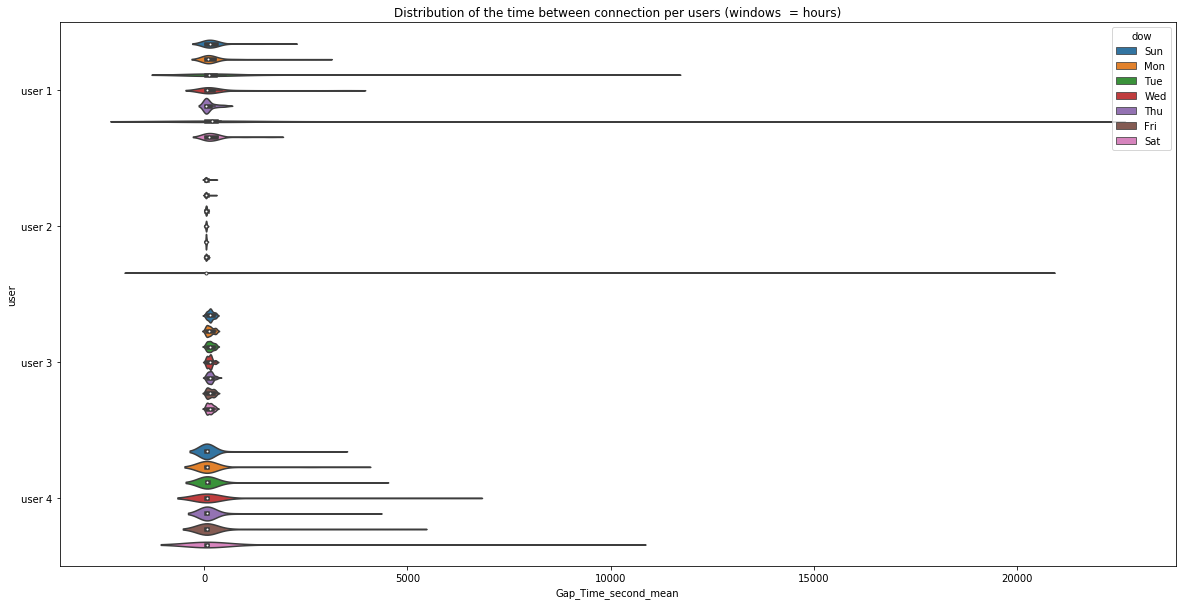

In [255]:
plt.figure(figsize=(20,10))
sns.violinplot(x="Gap_Time_second_mean",y="user" ,data=DF_plot_Hour, hue="dow")
plt.title("Distribution of the time between connection per users for each days (windows  = hours)")
plt.show()

##### III.1.2.2 - By number of connection <a name="Bynumberofconnection"></a>

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



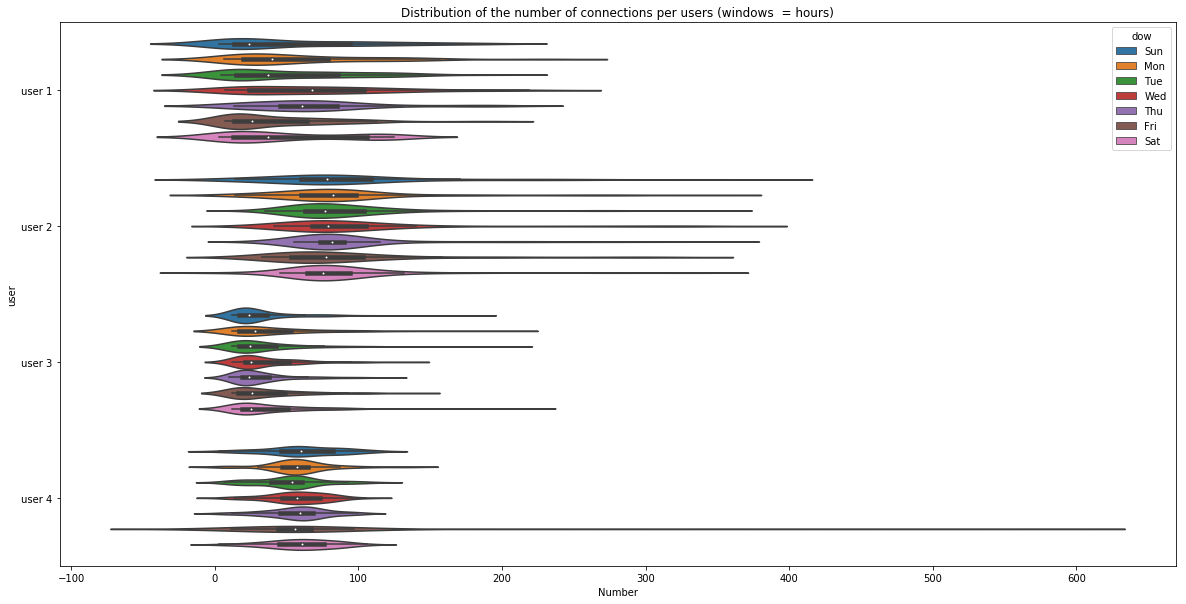

In [247]:
plt.figure(figsize=(20,10))
sns.violinplot(x="Number", y="user" ,data=DF_plot_Hour, hue="dow")
plt.title("Distribution of the number of connections per users for each days (windows  = hours)")
plt.show()

##### III.1.2.3 - By distance deviation <a name="Bydistancedeviation"></a>

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



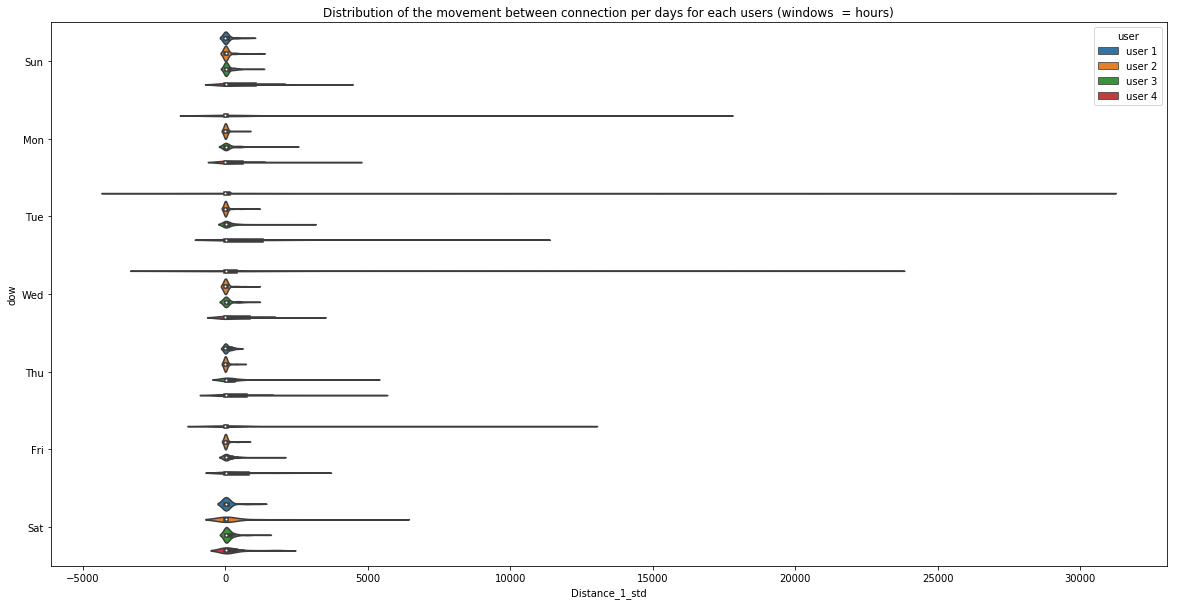

In [283]:
plt.figure(figsize=(20,10))
sns.violinplot(x="Distance_1_std", y="dow" ,data=DF_plot_Hour , hue="user")
plt.title("Distribution of the movement between connection per days for each users (windows  = hours)")
plt.show()

### III.2 - User activities <a name="Useractivities"></a>

[UP](#Datavisualization)

#### III.2.1 - User activities per day <a name="Useractivitiesperday"></a>

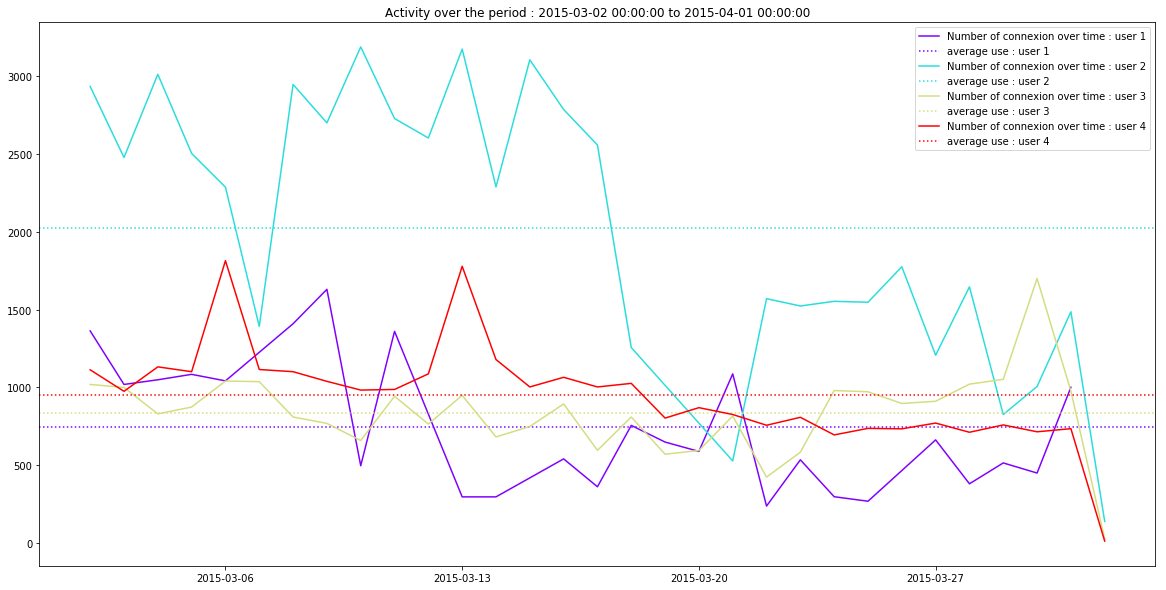

In [107]:
colors = plt.cm.get_cmap("rainbow", 4)
plt.figure(figsize=(20,10))
for i,data in enumerate(List_Data_Grouped_Days):
#for i in Dico_:
    #data = Dico_[i]
    #ax = plt.subplot(111)
    #ax.bar(data.index,data["Number"], color = colors(i), width = 0.03)
    #ax.xaxis_date()
    plt.plot(data.index,data["Number"], label="Number of connexion over time : user {}".format(i+1), c = colors(i))
    plt.axhline(data["Number"].mean(), linestyle=':', label="average use : user {}".format(i+1), c = colors(i))
    plt.title("Activity over the period : {0} to {1}".format(data.index.min(), data.index.max()))
plt.legend(loc = 1)
plt.show()

#### III.2.2 - User activities per hour <a name="Useractivitiesperhour"></a>

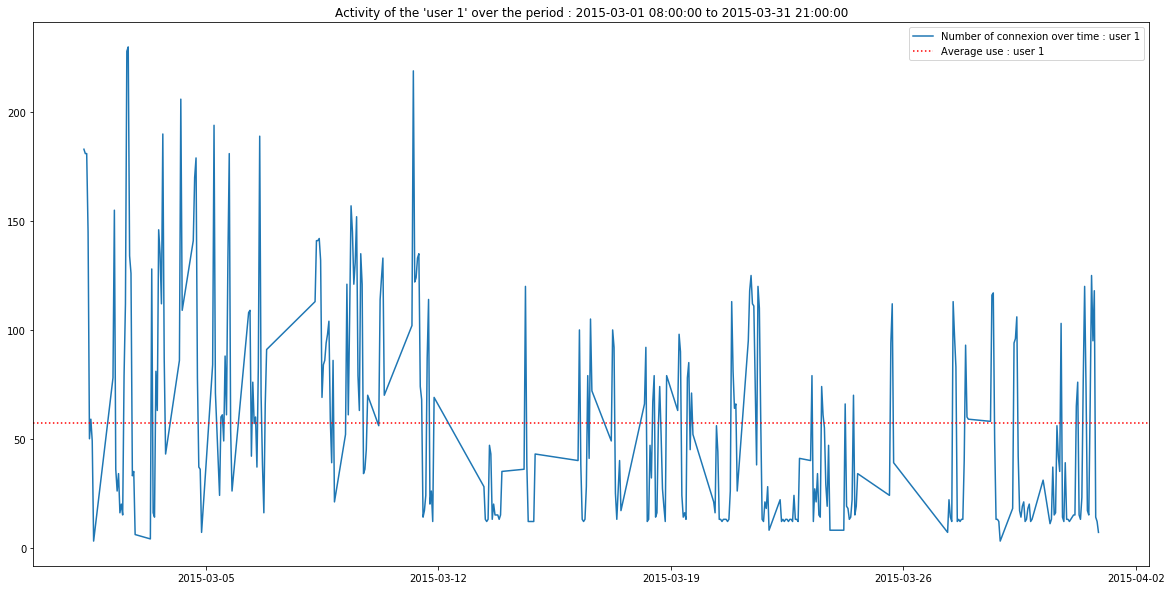

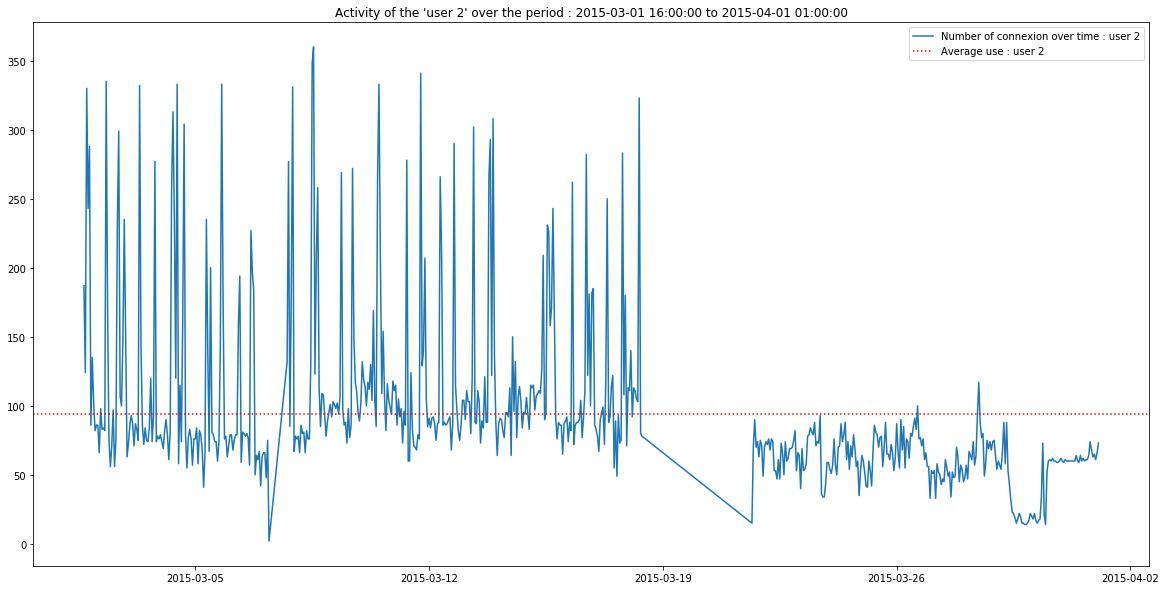

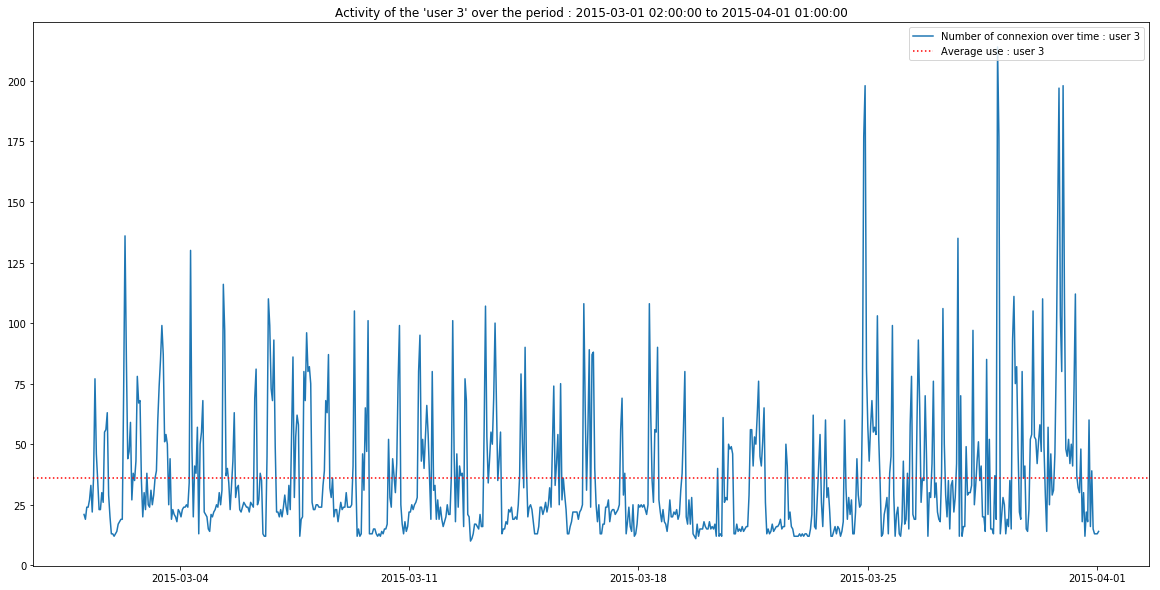

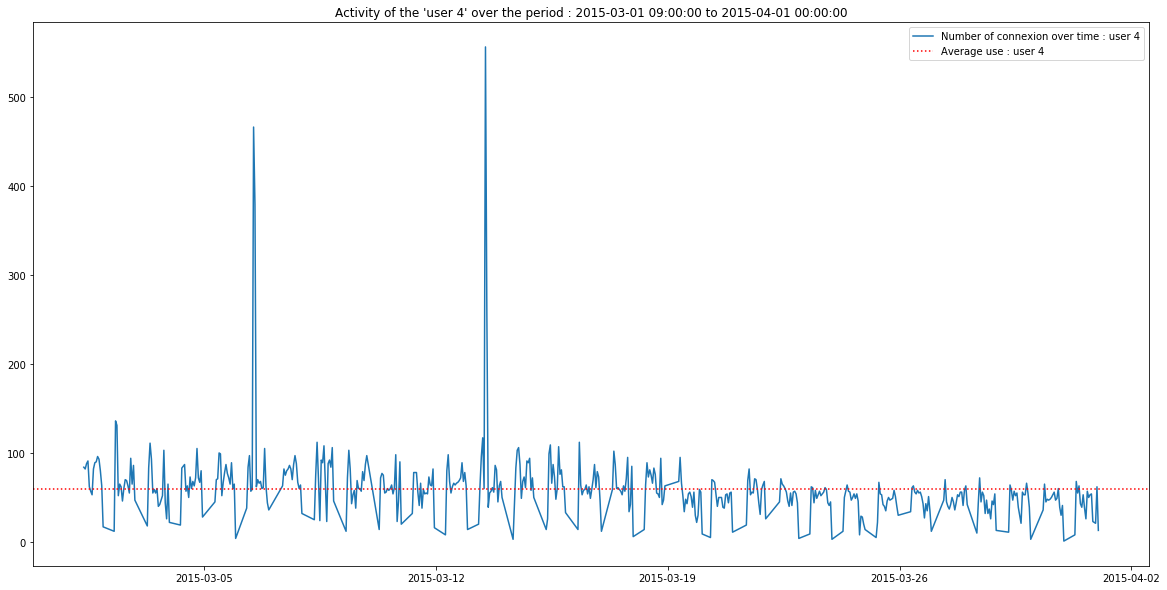

In [108]:
for i,data in enumerate(List_Data_Grouped_Hours):
    plt.figure(figsize=(20,10))
    plt.plot(data.index,data["Number"], label="Number of connexion over time : user {}".format(i+1))
    plt.axhline(data["Number"].mean(),c="red", linestyle=':', label="Average use : user {}".format(i+1))
    plt.title("Activity of the 'user {0}' over the period : {1} to {2}".format(i+1, data.index.min(), data.index.max()))
    plt.legend(loc=1)
    plt.show()

#### III.2.3 - User activities per minutes  <a name="Useractivitiesperminutes"></a>

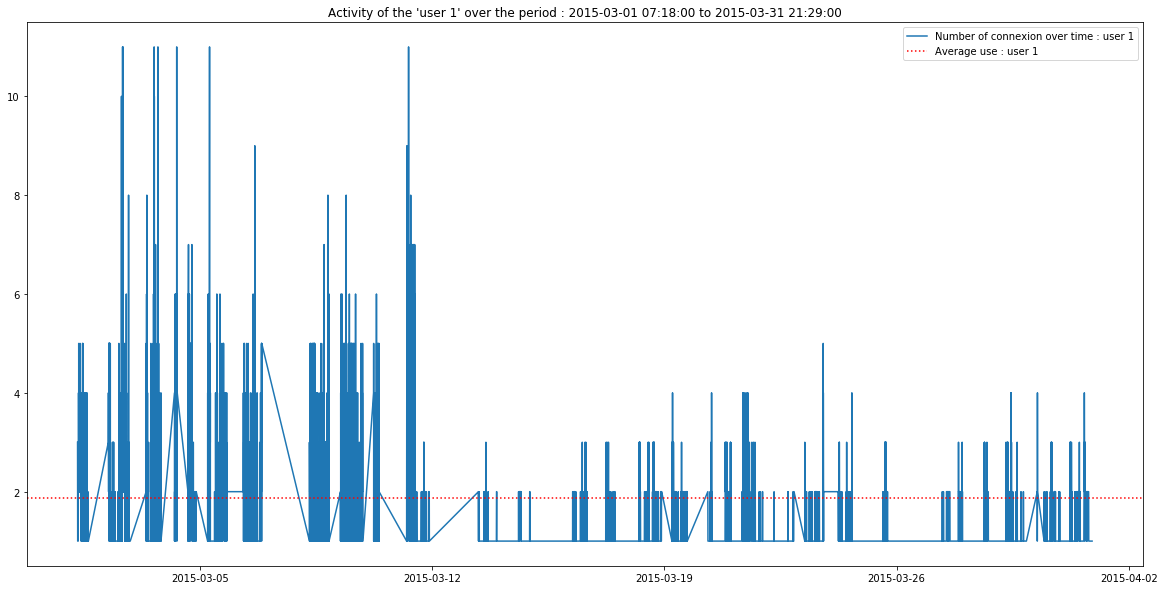

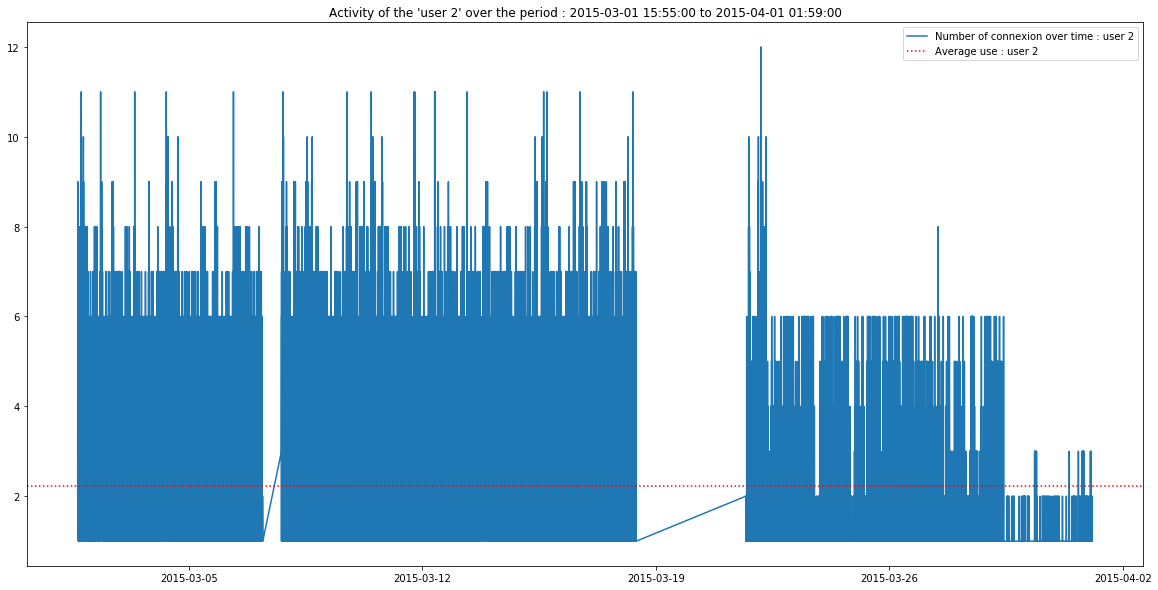

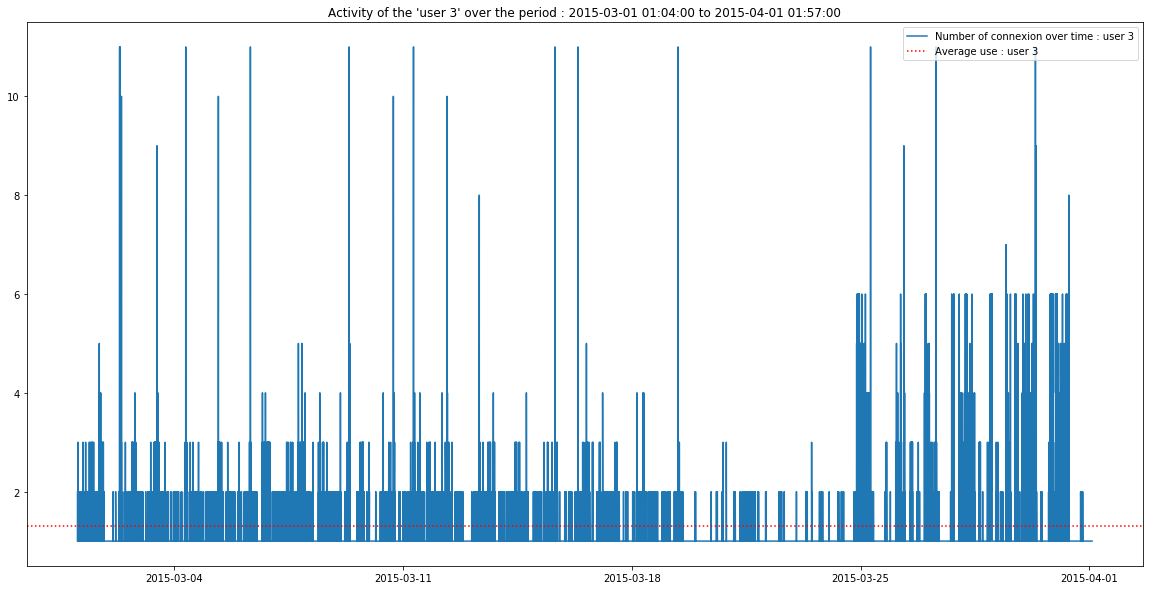

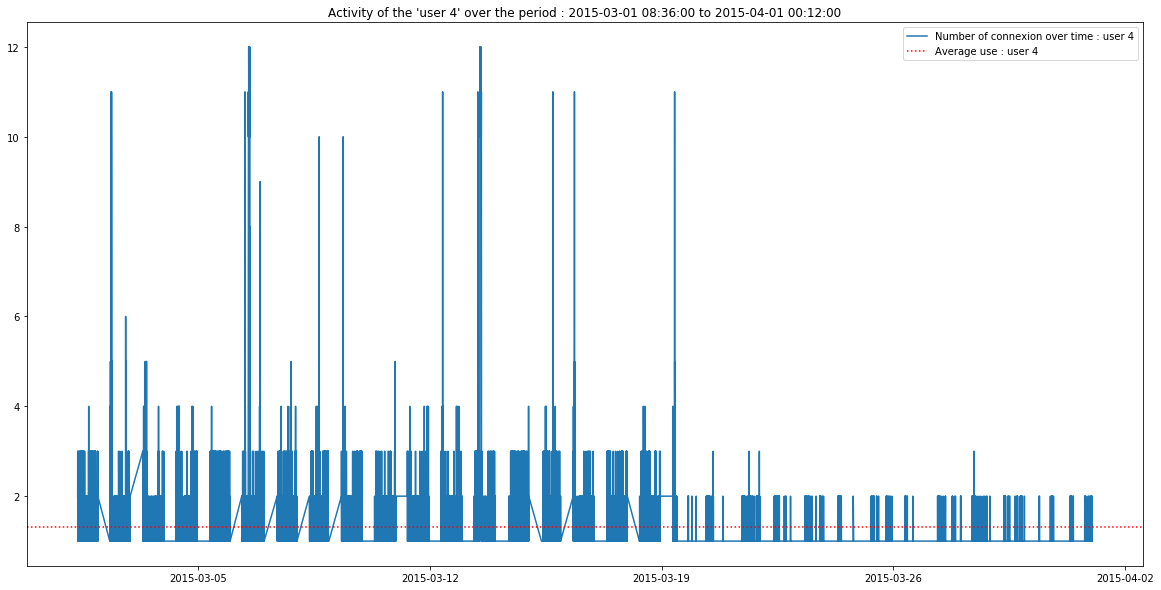

In [109]:
for i,data in enumerate(List_Data_Grouped_Minutes):
    plt.figure(figsize=(20,10))
    plt.plot(data.index,data["Number"], label="Number of connexion over time : user {}".format(i+1))
    plt.axhline(data["Number"].mean(),c="red", linestyle=':', label="Average use : user {}".format(i+1))
    plt.title("Activity of the 'user {0}' over the period : {1} to {2}".format(i+1, data.index.min(), data.index.max()))
    plt.legend(loc=1)
    plt.show()

### III.3 - Localisation of the users <a name="Localisationoftheusers"></a> 

[UP](#Datavisualization)

In [59]:
py.iplot(Plot3Dly_Users(), filename='Activity user')

## IV - Data modeling <a name="Datamodeling"></a>

[TOP](#TOP)

In this part we are using multiple models of Isolation Forest using different set of features to find out abnormality and windows time frame (Hours, minutes).

Those models permits to find out abnormal behavior over aggregated informations.

However to get a better detail of the weirdness and anomaly of connection per users, we made models based on the raw datas so that we could take into consideration the distance between each connection and the gap of time. 

It helps to find out VPN users for instance.

### IV.1 - Anomaly detection based on user activity using Isolation Forest <a name="AnomalydetectionbasedonuseractivityusingIsolationForest"></a> 

#### IV.1.1 - Activity per hour <a name="Activityperhour"></a> 

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


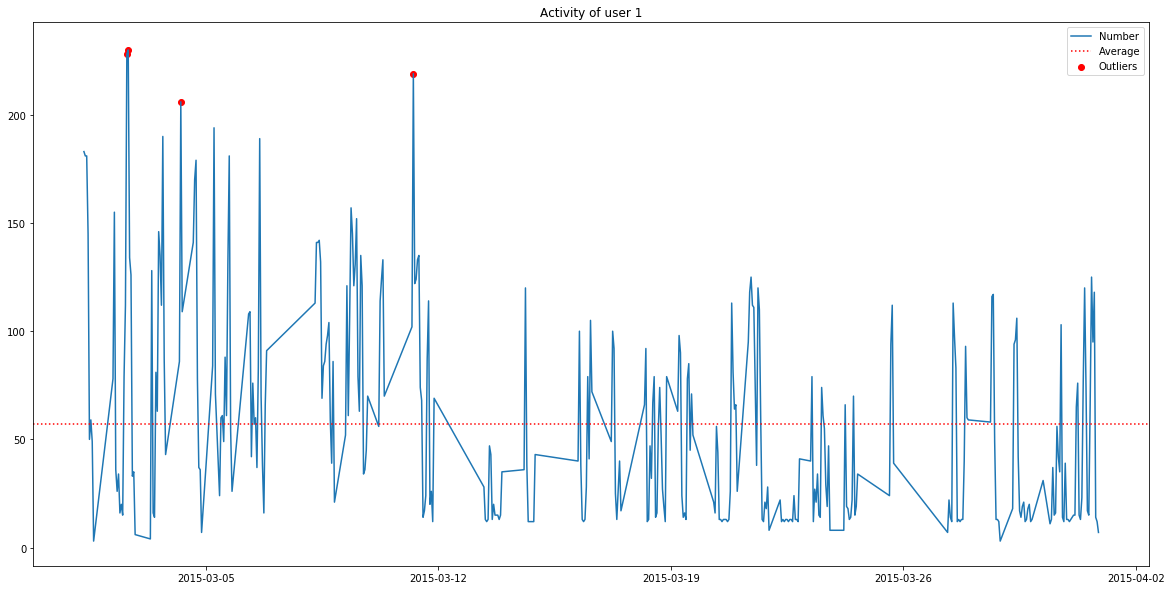

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


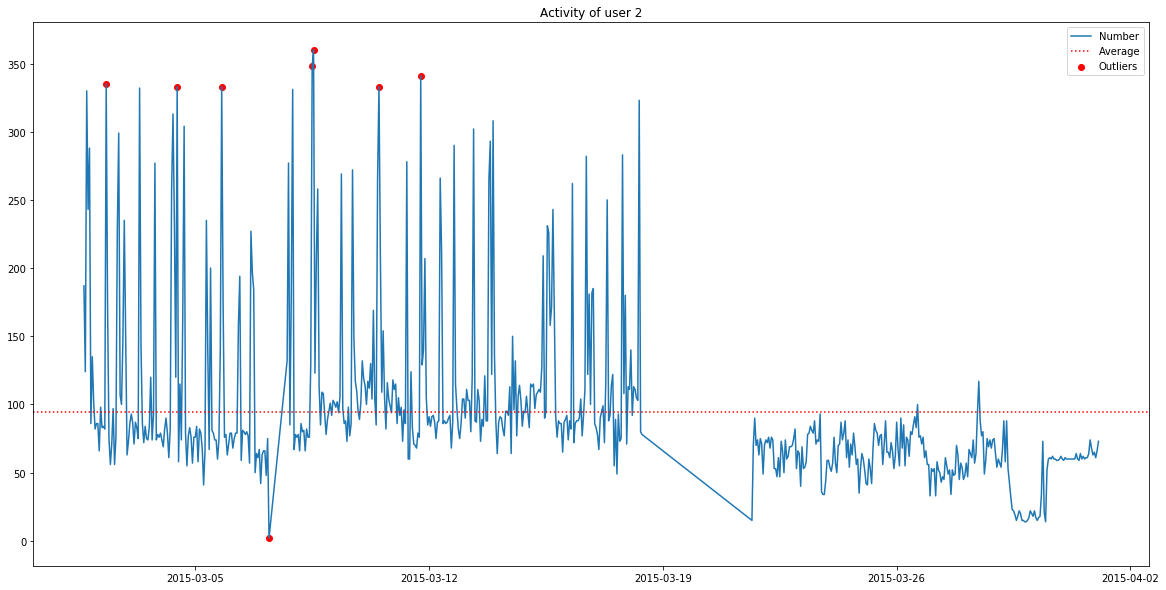

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


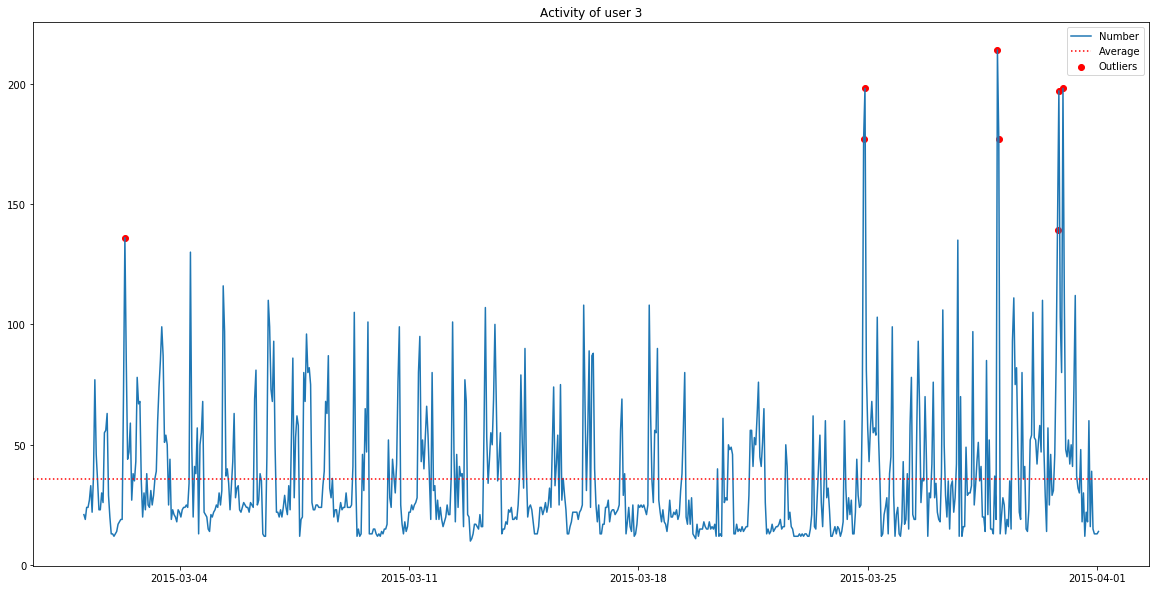

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


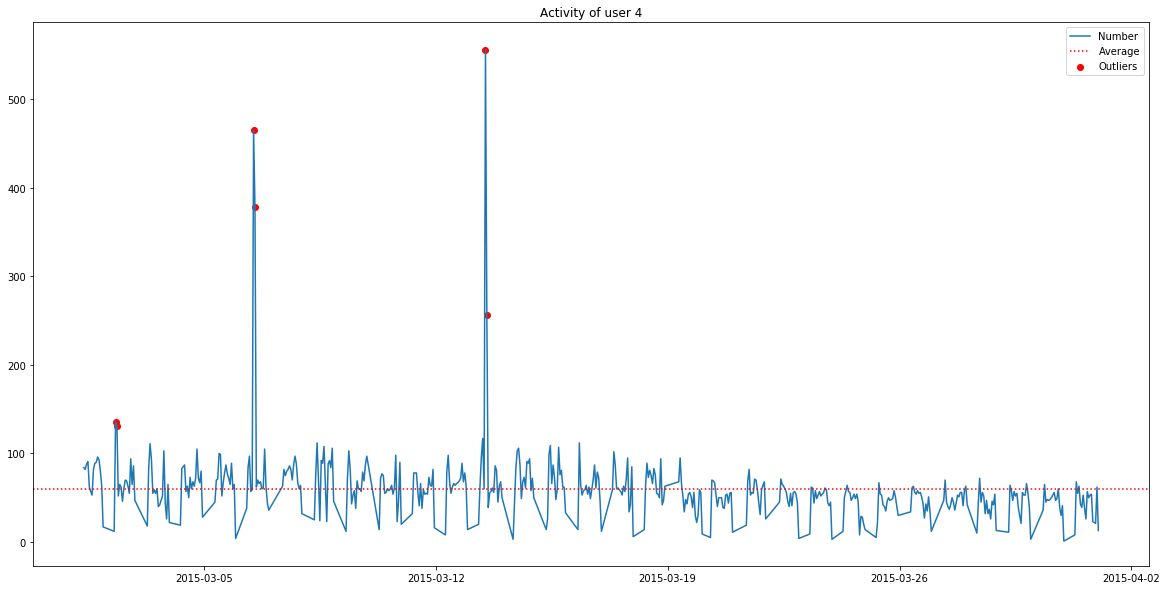

In [667]:
for i, data in enumerate(List_Data_Grouped_Hours): 
    Anomaly_(data=data, var=["Number"]).__Graph__(title_="Activity of user {0}".format(i+1))

#### IV.1.2 - Activity per minute <a name="Activityperminute"></a> 

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



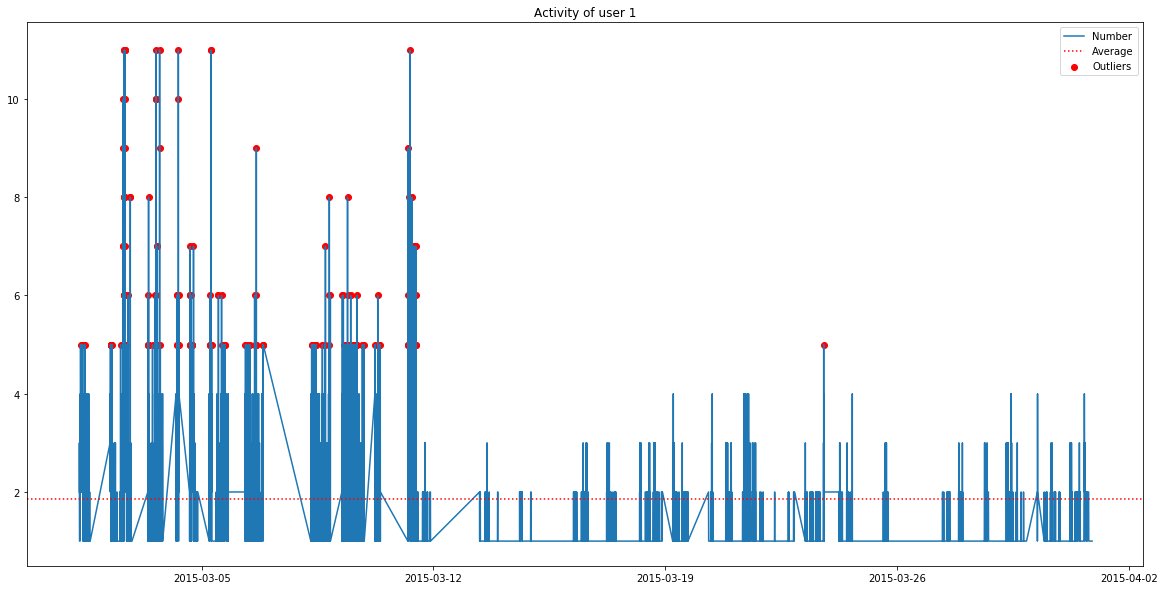

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



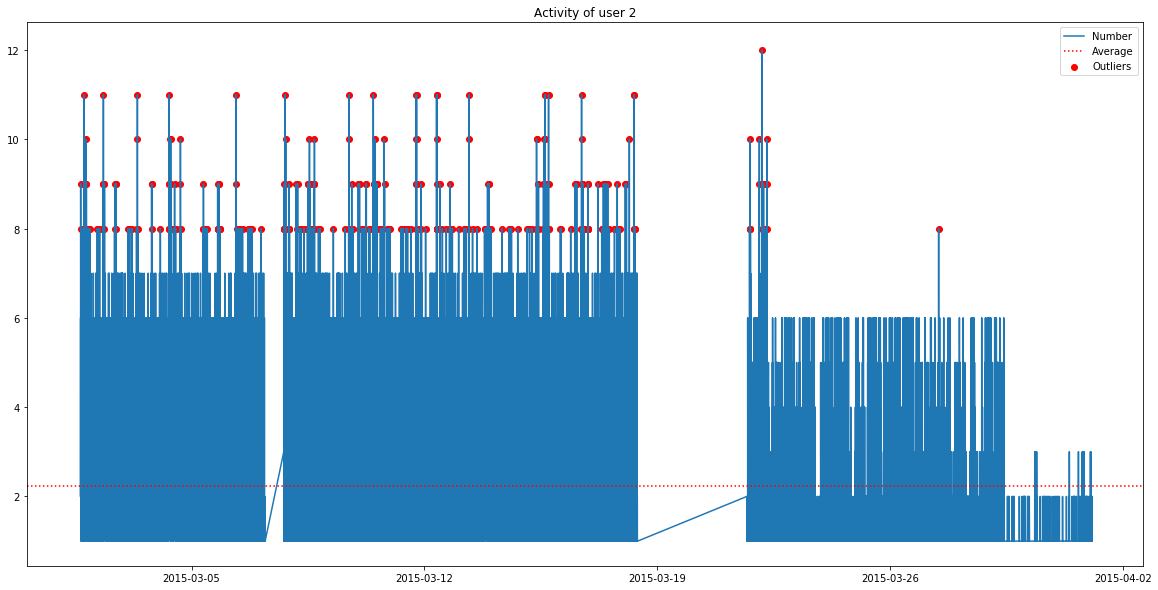

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



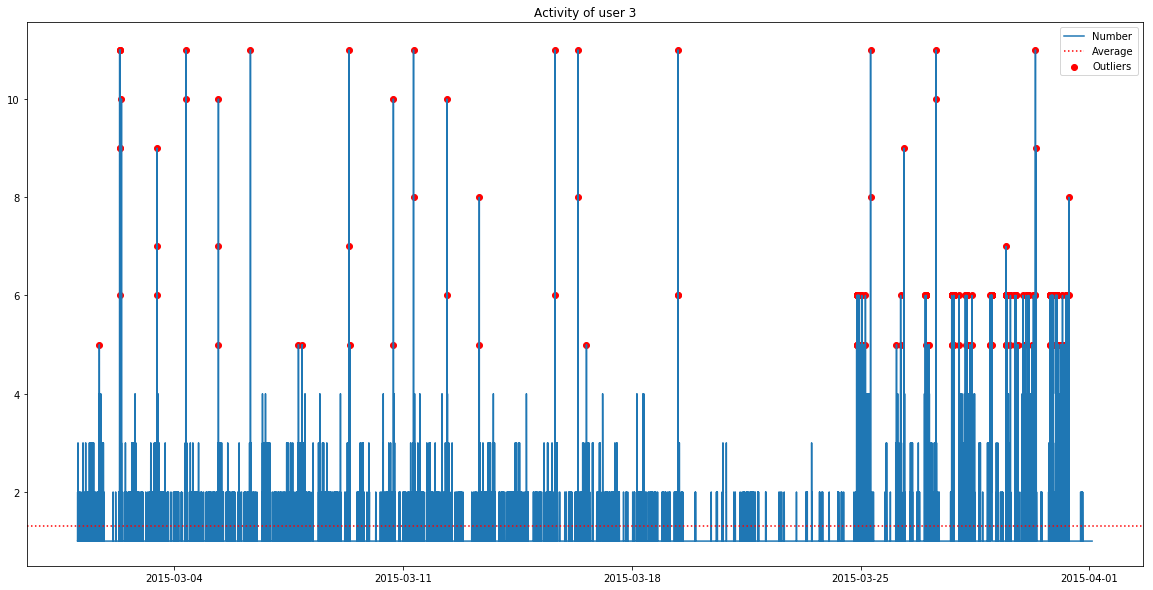

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



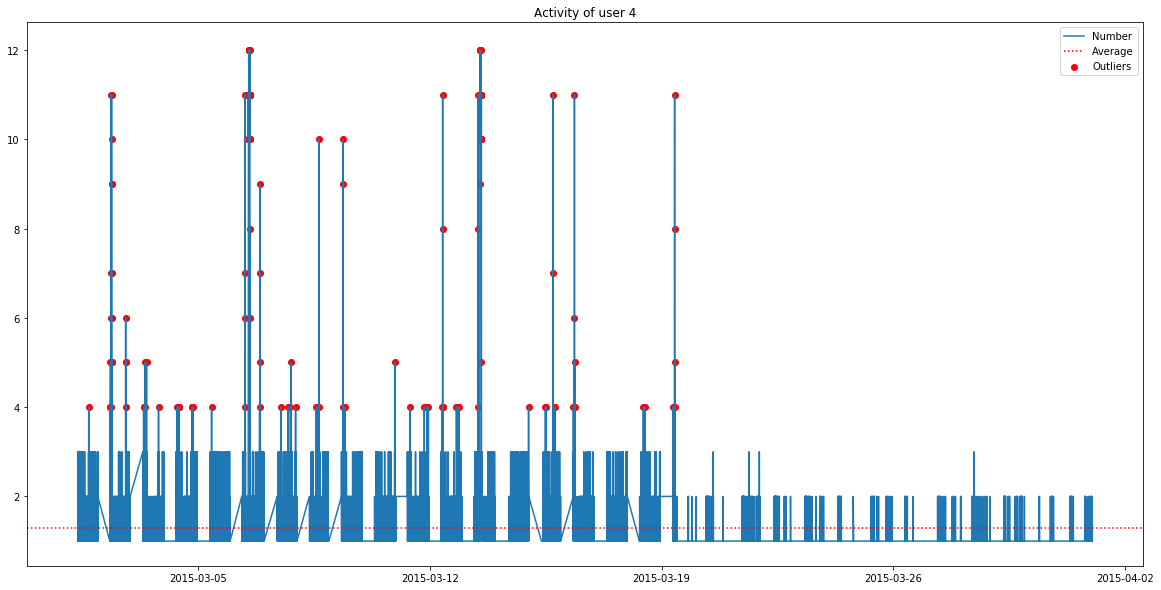

In [709]:
for i, data in enumerate(List_Data_Grouped_Minutes): 
    Anomaly_(data=data, var=["Number"]).__Graph__(title_="Activity of user {0}".format(i+1))

### IV.2 - Anomaly detection based on user behavior using Isolation Forest  <a name="AnomalydetectionbasedonuserbehaviorusingIsolationForest"></a>

#### IV.2.1 - Activity per hour <a name="Activityperhour2"></a>

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



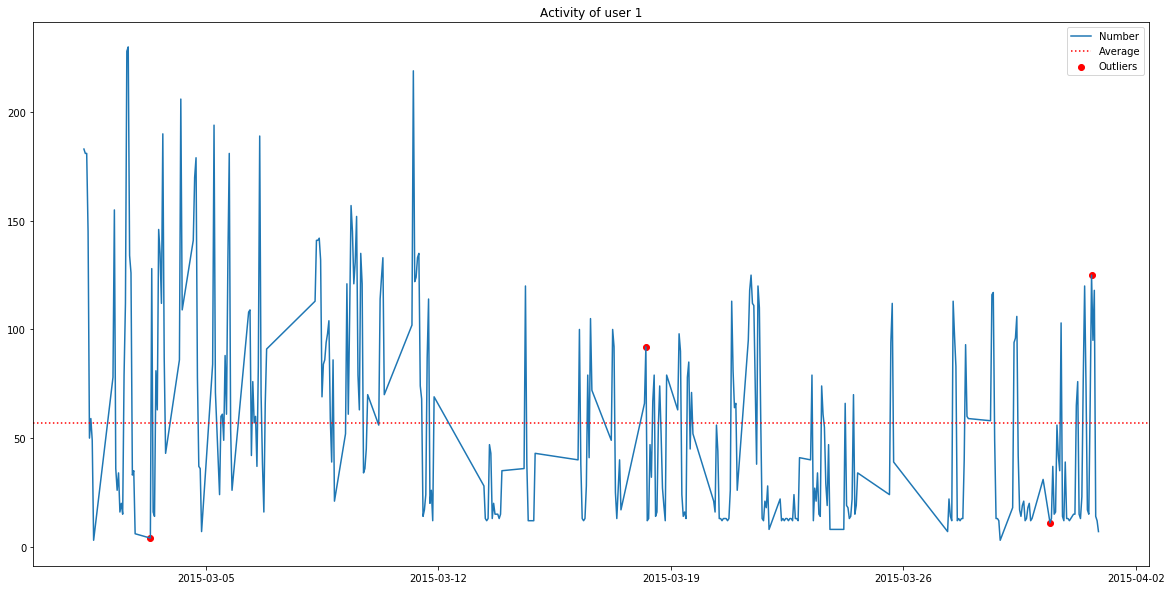

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



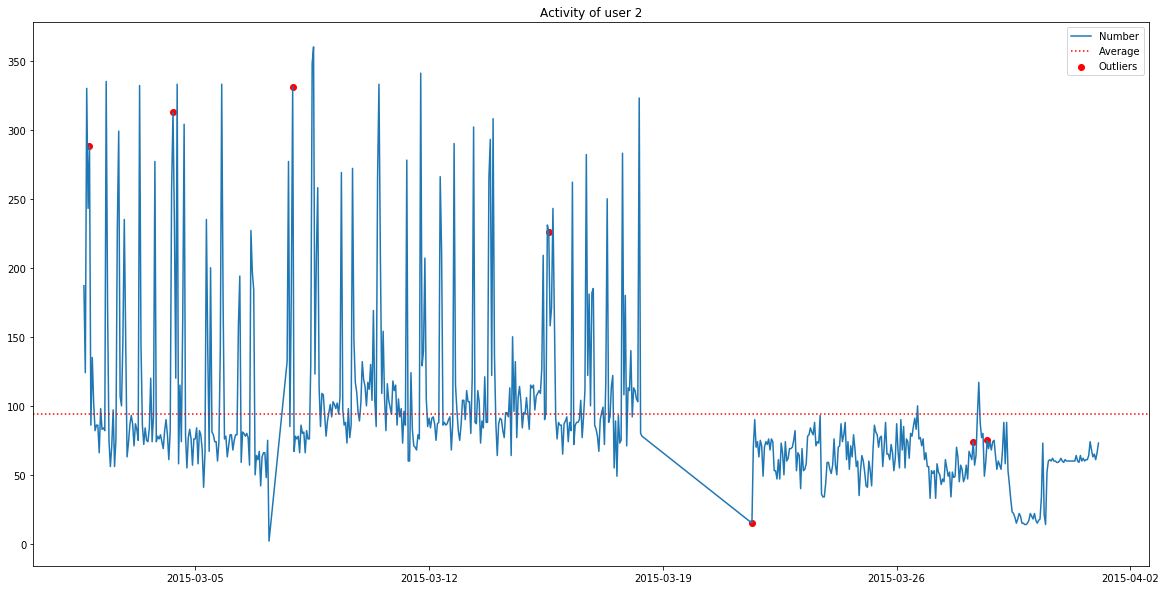

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



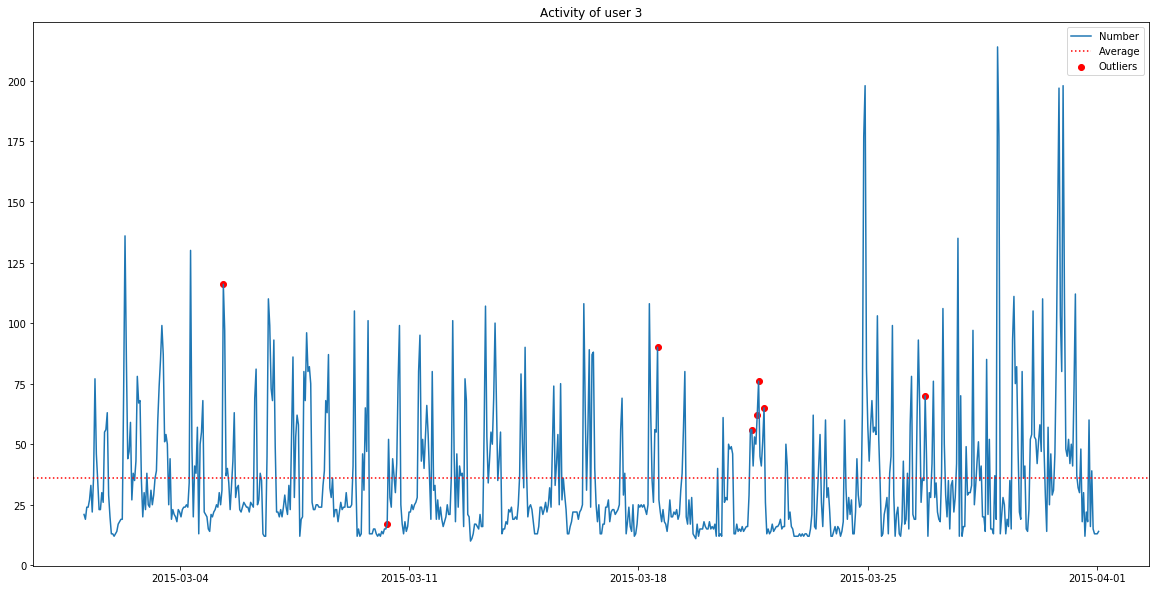

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



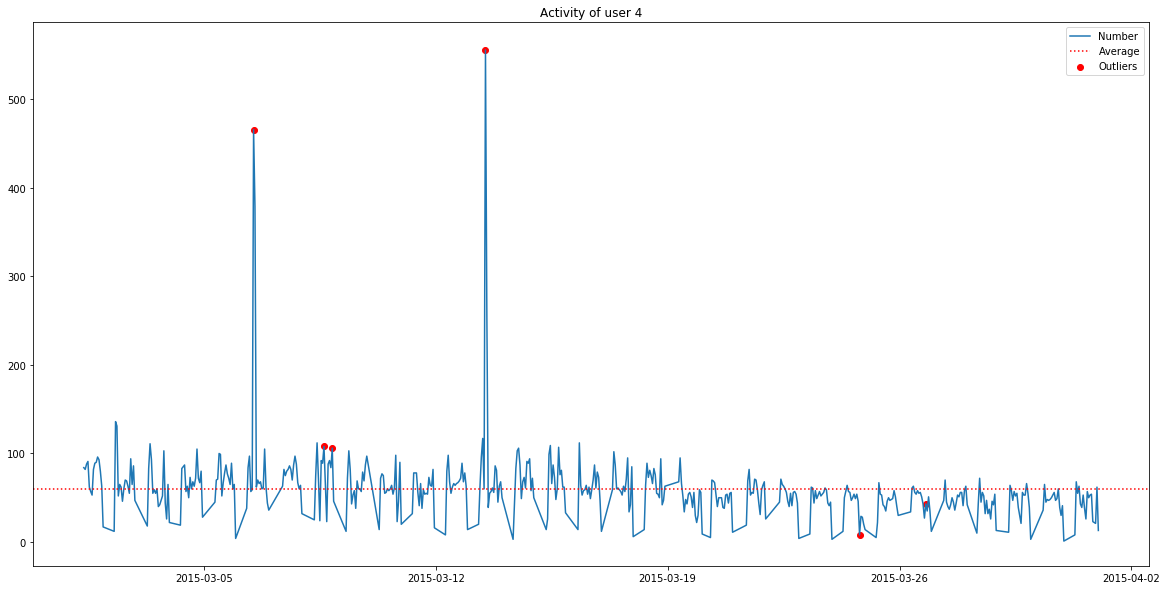

In [250]:
for i, data in enumerate(List_Data_Grouped_Hours): 
    Anomaly_(data=data, var=["Number",'Distance_Centroid_sum','Distance_1_max','Distance_1_sum','Distance_1_std','Gap_Time_second_sum', 'Time_Period', 'dow']).__Graph__(title_="Activity of user {0}".format(i+1))

#### IV.2.2 - Activity per minute <a name="Activityperminute2"></a>

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



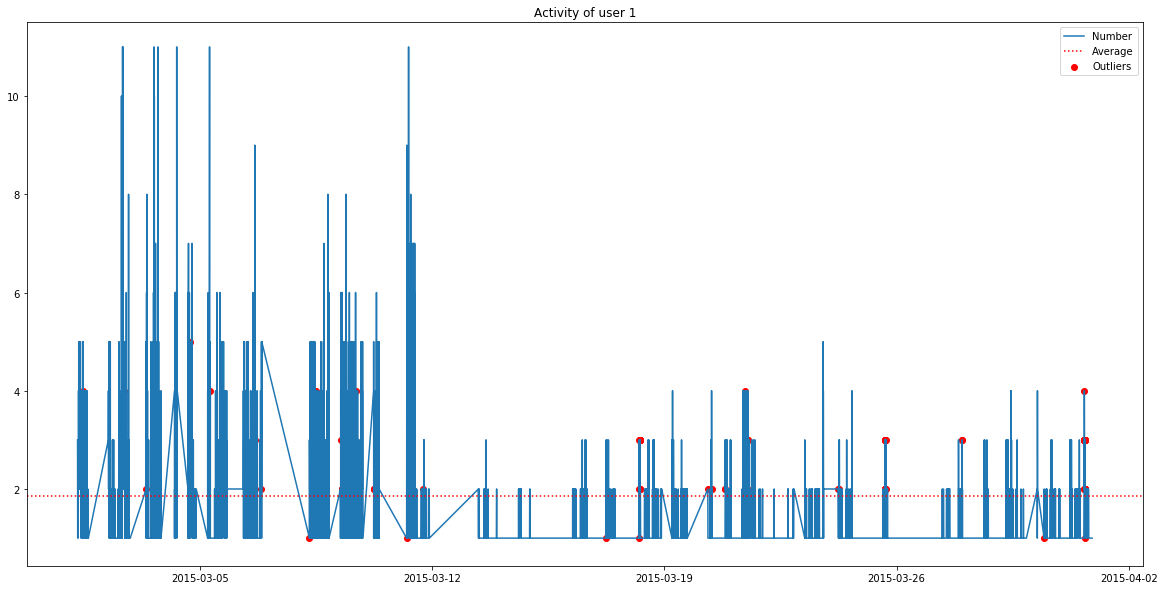

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



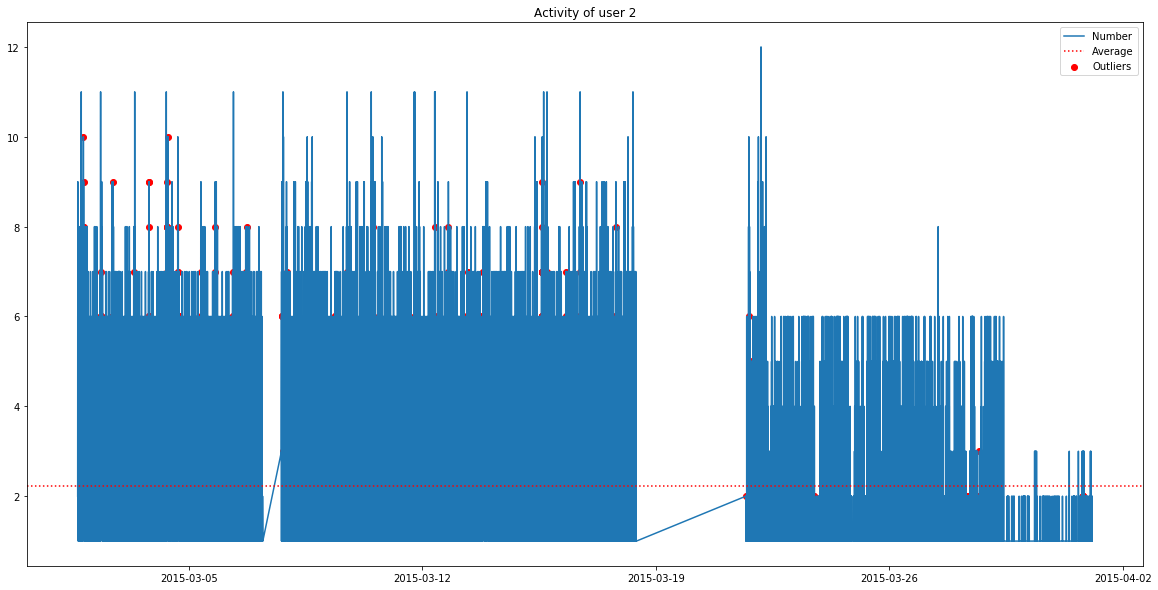

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



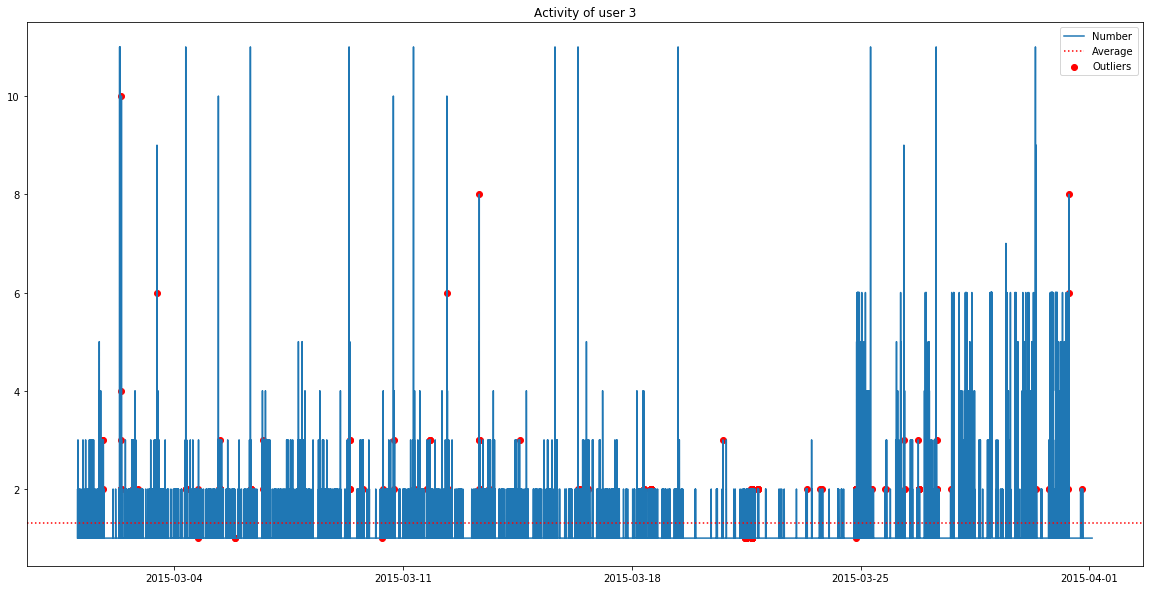

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



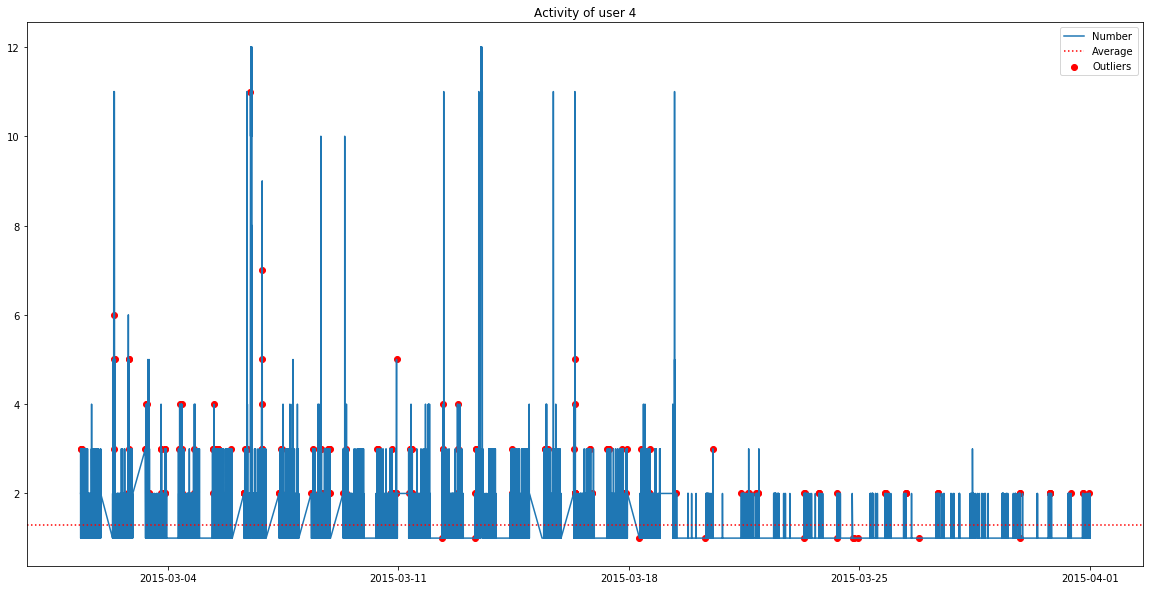

In [251]:
for i, data in enumerate(List_Data_Grouped_Minutes): 
    Anomaly_(data=data, var=["Number",'Distance_Centroid_sum','Distance_1_max','Distance_1_sum','Distance_1_std','Gap_Time_second_sum', 'Time_Period', 'dow']).__Graph__(title_="Activity of user {0}".format(i+1))

### IV.3 - Anomaly detection based on distance between each connection using Isolation Forest <a name="AnomalydetectionbasedondistancebetweeneachconnectionusingIsolationForest"></a>

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



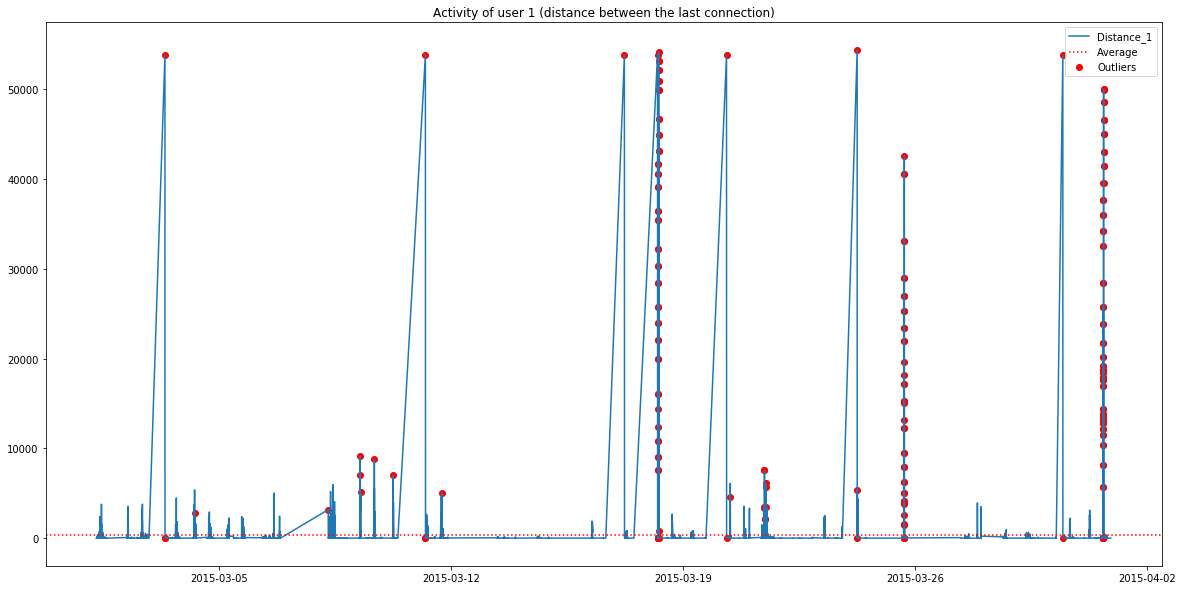

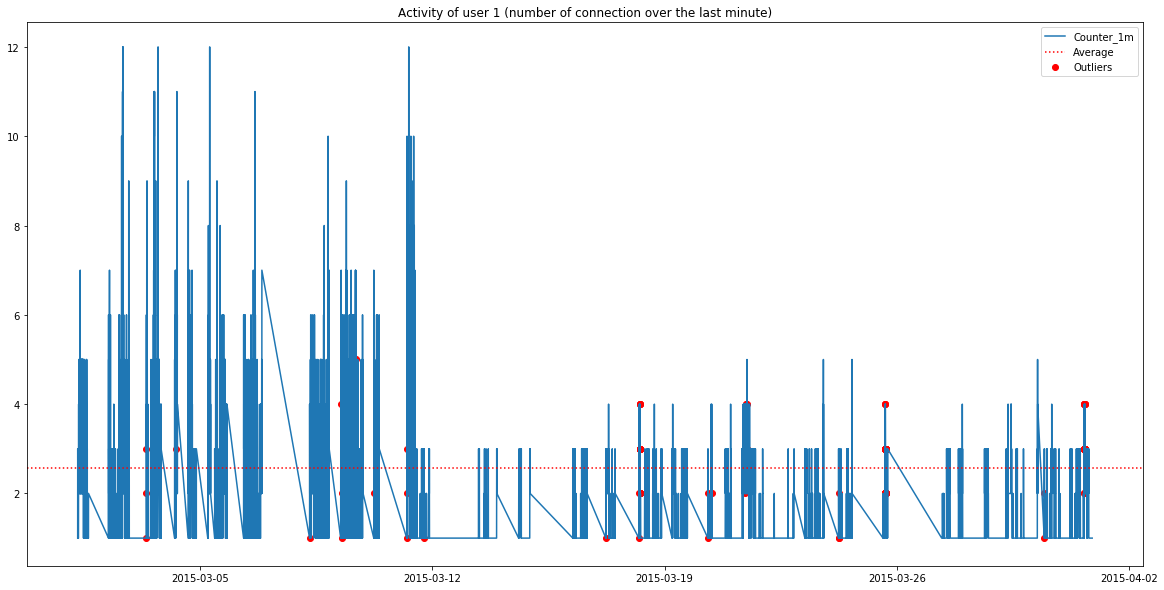

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



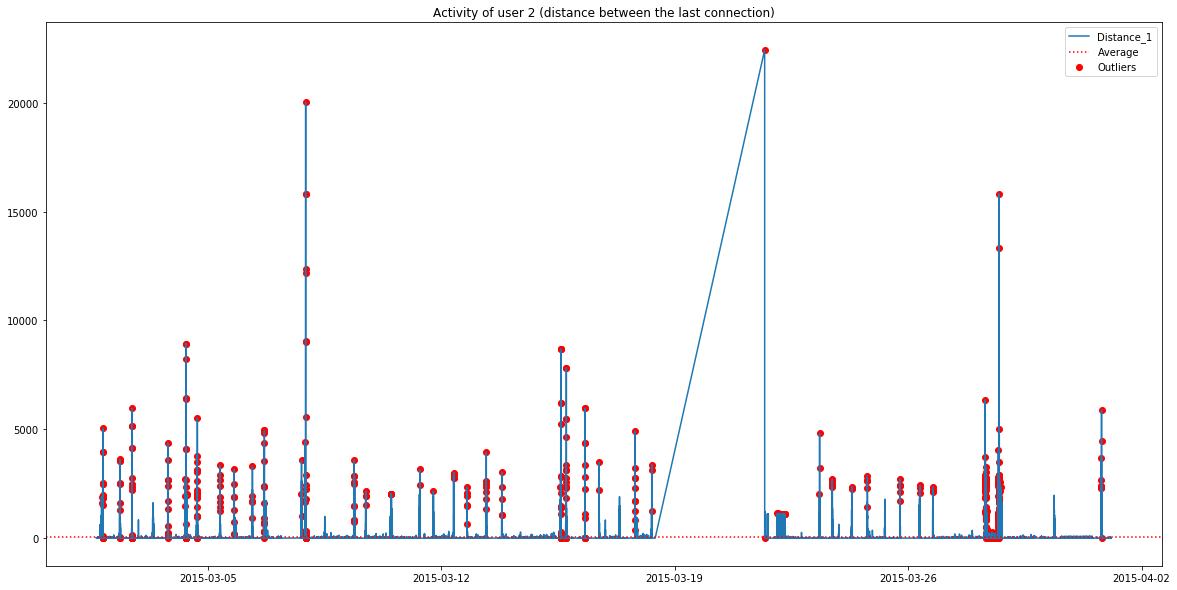

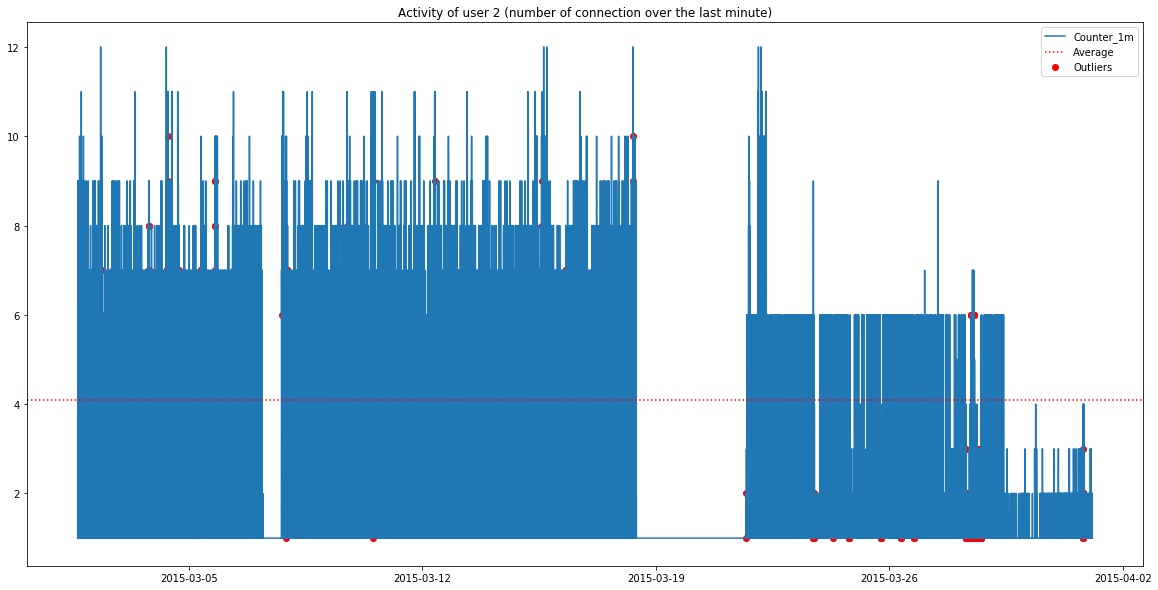

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



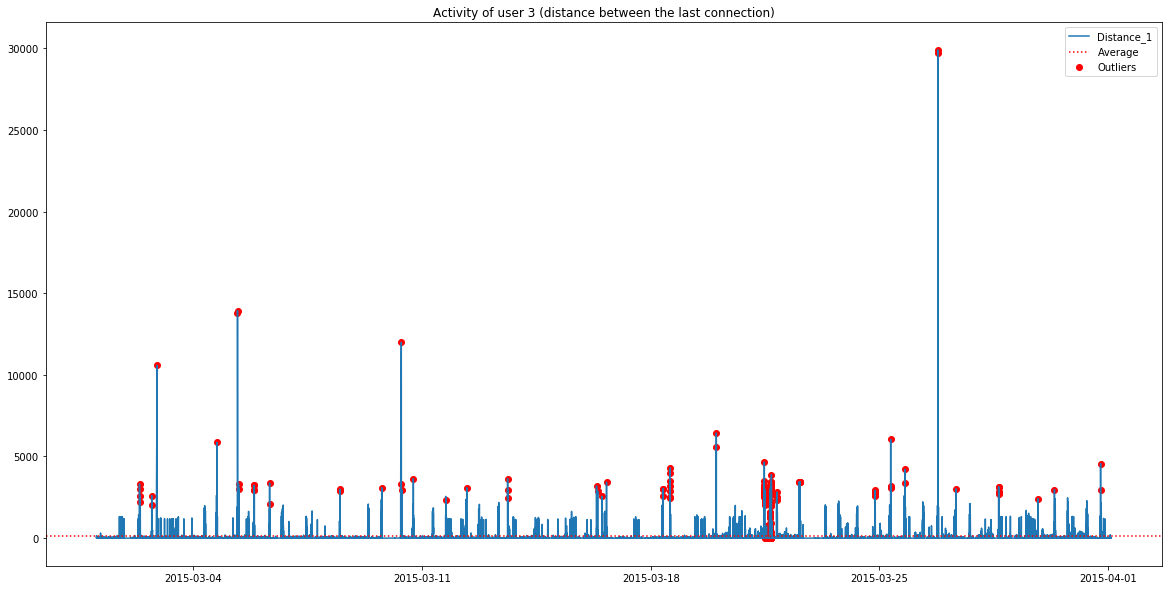

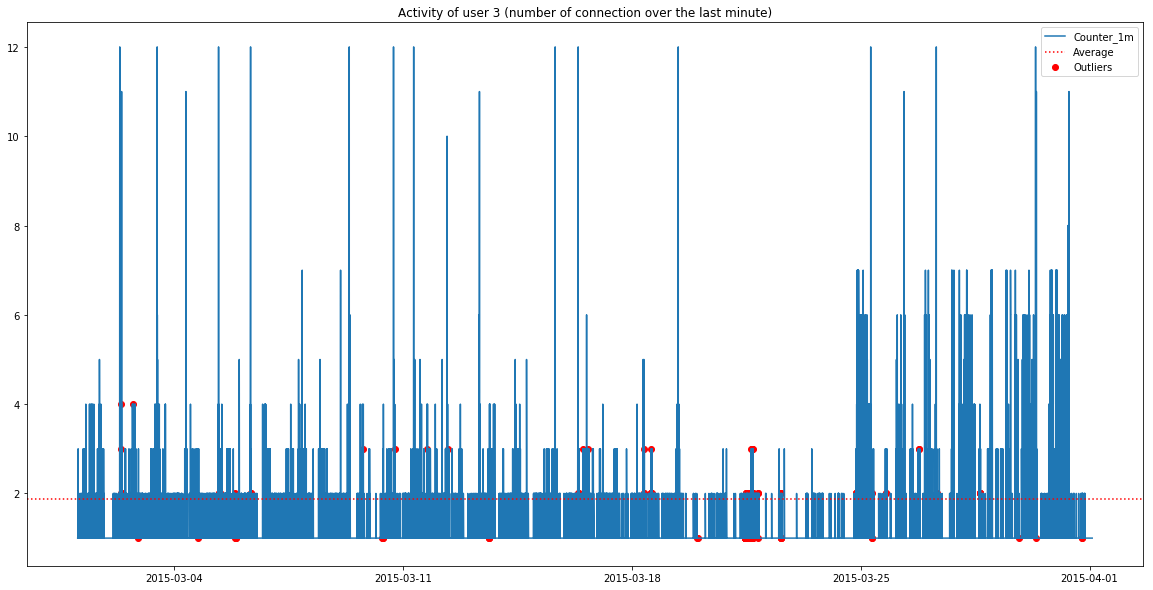

C:\Users\ALytics\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



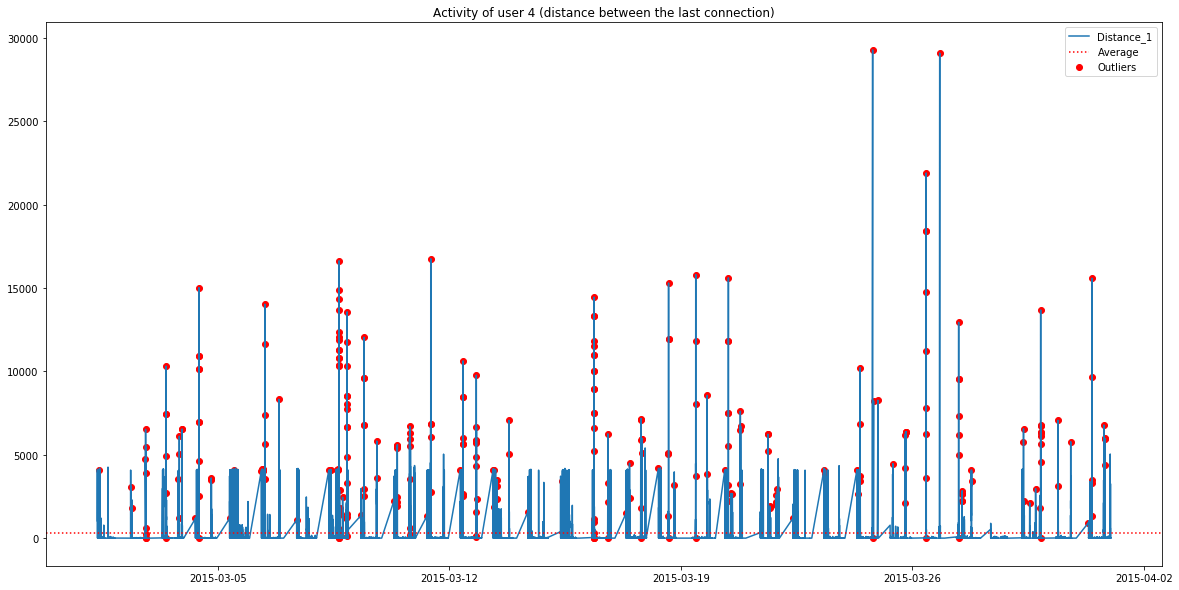

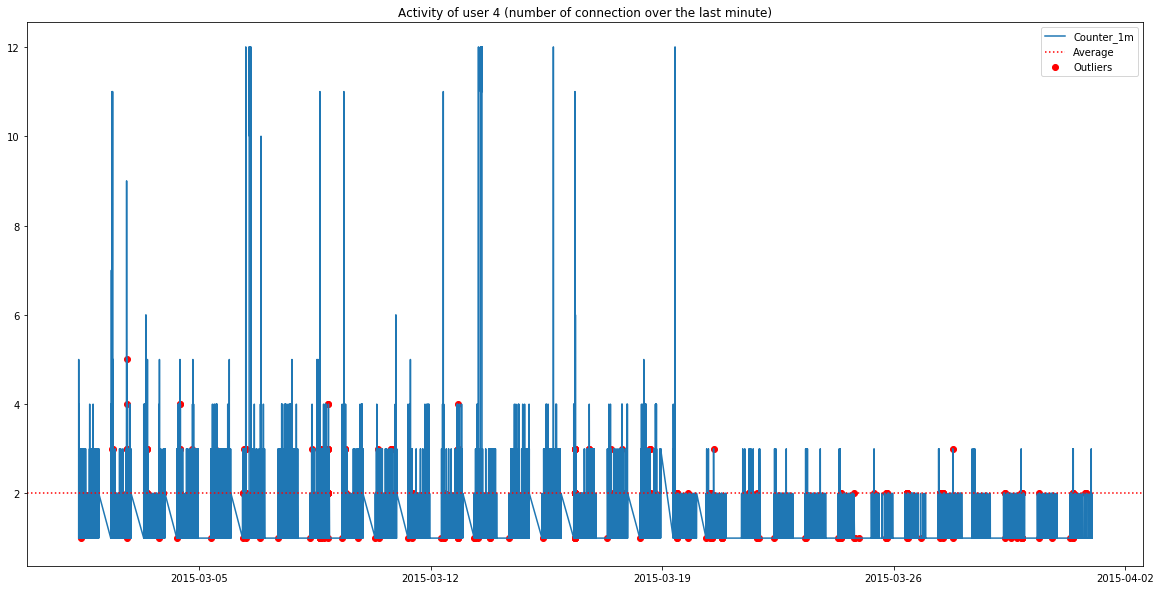

In [13]:
Model_users_Distance=list()
for i, data in enumerate(List_Data): 
    Model_users_Distance.append(Anomaly_(data=data, var=["Distance_1","Gap_Time_second","Distance_t0","Distance_Centroid",'Distance_1_sum_1m','Distance_1_max_1m','Rank_location'], var_target="Distance_1"))
    Model_users_Distance[i].__detection__()
    Model_users_Distance[i].__Graph__(title_="Activity of user {0} (distance between the last connection)".format(i+1))
    Model_users_Distance[i].__Graph__(var_target="Counter_1m",title_="Activity of user {0} (number of connection over the last minute)".format(i+1))

### Focus on the user 1 between 2015-03-18 05:51:18 and 2015-03-18 06:02:52


In [15]:
print("---- Abnormal connections for the user 1 ----")
Model_users_Distance[0].data[(Model_users_Distance[0].data.index>="2015-03-18 05:51:18")&(Model_users_Distance[0].data.index<="2015-03-18 06:02:52")][["latitude","longitude","Abnormality_Score","Abnormality","Distance_1","Rank_location"]]

---- Abnormal connections for the user 1 ----


,latitude,longitude,Abnormality_Score,Abnormality,Distance_1,Rank_location
Time,,,,,,
2015-03-18 05:51:18,-15.685937,-64.980564,-0.121335,1,4748.501032,3
2015-03-18 05:51:48,-15.685937,-64.980564,-0.051748,1,0.000000,4
2015-03-18 05:52:03,-15.620386,-64.959471,-0.151641,-1,7597.900188,1
2015-03-18 05:52:18,-15.685937,-64.980564,-0.146840,-1,7597.900188,5
2015-03-18 05:52:48,-15.608349,-64.954293,-0.165584,-1,9035.713655,1
2015-03-18 05:53:18,-15.685937,-64.980564,-0.153903,-1,9035.713655,6
2015-03-18 05:53:29,-15.595012,-64.942896,-0.177009,-1,10841.692016,1
2015-03-18 05:53:48,-15.685937,-64.980564,-0.171064,-1,10841.692016,7
2015-03-18 05:54:19,-15.583850,-64.932294,-0.180616,-1,12425.738319,1


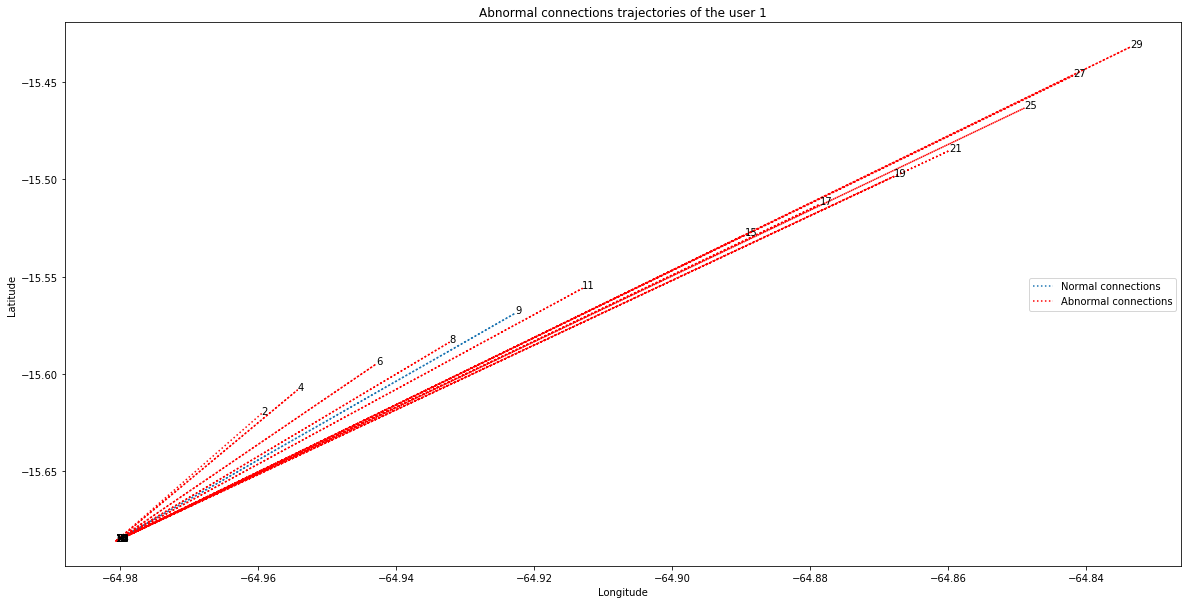

In [64]:
plt.figure(figsize=(20,10))
plt.plot(Model_users_Distance[0].data[(Model_users_Distance[0].data.index>="2015-03-18 05:51:18")&(Model_users_Distance[0].data.index<="2015-03-18 06:02:52")&(Model_users_Distance[0].data.Abnormality>0)].longitude, Model_users_Distance[0].data[(Model_users_Distance[0].data.index>="2015-03-18 05:51:18")&(Model_users_Distance[0].data.index<="2015-03-18 06:02:52")&(Model_users_Distance[0].data.Abnormality>0)].latitude, linestyle=":", label="Normal connections")
plt.plot(Model_users_Distance[0].data[(Model_users_Distance[0].data.index>="2015-03-18 05:51:18")&(Model_users_Distance[0].data.index<="2015-03-18 06:02:52") &(Model_users_Distance[0].data.Abnormality<0)].longitude, Model_users_Distance[0].data[(Model_users_Distance[0].data.index>="2015-03-18 05:51:18")&(Model_users_Distance[0].data.index<="2015-03-18 06:02:52")&(Model_users_Distance[0].data.Abnormality<0)].latitude, linestyle=":",c='red',  label="Abnormal connections")
for i in range(len(Model_users_Distance[0].data[(Model_users_Distance[0].data.index>="2015-03-18 05:51:18")&(Model_users_Distance[0].data.index<="2015-03-18 06:02:52")].longitude)):
    plt.text(Model_users_Distance[0].data[(Model_users_Distance[0].data.index>="2015-03-18 05:51:18")&(Model_users_Distance[0].data.index<="2015-03-18 06:02:52")].longitude.iloc[i], Model_users_Distance[0].data[(Model_users_Distance[0].data.index>="2015-03-18 05:51:18")&(Model_users_Distance[0].data.index<="2015-03-18 06:02:52")].latitude.iloc[i],str(i))
plt.title("Abnormal connections trajectories of the user 1")
plt.legend(loc=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

#### Other representation

In [60]:
py.iplot(Plot3Dly_User1_abnormal(), filename='Activity user 1') 